In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import xlrd
from datetime import datetime
import matplotlib.pyplot as plt
import scipy.optimize as spop
# кульбак лейбнер
from scipy.special import kl_div
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import accuracy_score
# Импорт openpyxl
import openpyxl
from openpyxl import load_workbook
import random
from scipy.special import rel_entr
import torch
# from torch.nn.functional import softmax
from scipy.special import kl_div
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import _LRScheduler
from multiprocessing import cpu_count
from pathlib import Path
from scipy.special import rel_entr

In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda'

In [3]:
resultDataSet = pd.read_csv('credit_score_df.csv')
resultDataSet['report_date']  = pd.to_datetime(resultDataSet['report_date'])

In [4]:
resultDataSet = resultDataSet.rename(columns={'Unnamed: 0': 'Наименование показателя'})
resultDataSet = resultDataSet.set_index('Наименование показателя')

# Сейчас будем разделять столбцы

In [5]:
# нам необходимо прописать какие в принципе могут быть категории у каждой колонки

resultDataSet['Доля рынка'] = pd.Categorical(resultDataSet['Доля рынка'], categories=[0, 0.5, 1, 2, 3, 4, 5])
resultDataSet['Стабильность доли рынка'] = pd.Categorical(resultDataSet['Стабильность доли рынка'], categories=[0, 0.5, 1, 1.2, 1.5, 1.8, 2])
resultDataSet['Отклонение темпов роста'] = pd.Categorical(resultDataSet['Отклонение темпов роста'], categories=[0,0.5,1,1.5,2,2.5,3])
resultDataSet['Диверсификация дохода'] = pd.Categorical(resultDataSet['Диверсификация дохода'], categories=[0,0.6,1.2,1.8,2.4,3])
resultDataSet['География присутствия'] = pd.Categorical(resultDataSet['География присутствия'], categories=[0,1,2,3,4])
resultDataSet['Структура собственности'] = pd.Categorical(resultDataSet['Структура собственности'], categories=[-1,1,2])
resultDataSet['Доля государства'] = pd.Categorical(resultDataSet['Доля государства'], categories=[0,1,2,3,4,5])
resultDataSet['Частные акционеры'] = pd.Categorical(resultDataSet['Частные акционеры'], categories=[0,1,2,3])
resultDataSet['Качество управления'] = pd.Categorical(resultDataSet['Качество управления'], categories=[-3,-1.5,0,1.5,3])
resultDataSet['Деловая репутация'] = pd.Categorical(resultDataSet['Деловая репутация'], categories=[-1,0,1,2])
resultDataSet['Связанность операций с бизнесом'] = pd.Categorical(resultDataSet['Связанность операций с бизнесом'], categories=[0,1,2])
resultDataSet['Отчетность МСФО'] = pd.Categorical(resultDataSet['Отчетность МСФО'], categories=[0,1,2,3,4])
resultDataSet['Рейтинги НРА'] = pd.Categorical(resultDataSet['Рейтинги НРА'], categories=[0,2.5,4,5])
resultDataSet['Количество рейтингов НРА (баллы)'] = pd.Categorical(resultDataSet['Количество рейтингов НРА (баллы)'], categories=[1,1.2,2])
resultDataSet['Прогноз по рейтингам НРА'] = pd.Categorical(resultDataSet['Прогноз по рейтингам НРА'], categories=[0,1.2,2])
resultDataSet['ПОДДЕРЖКА МАКСИМУМ'] = pd.Categorical(resultDataSet['ПОДДЕРЖКА МАКСИМУМ'], categories=[0,8,10,16,20])

df_category = pd.get_dummies(resultDataSet, columns=['Доля рынка', 'Стабильность доли рынка', 'Отклонение темпов роста',
                                                     'Диверсификация дохода', 'География присутствия',
                                                     'Структура собственности', 'Доля государства', 'Частные акционеры', 'Качество управления', 'Деловая репутация', 'Связанность операций с бизнесом', 
                                                     'Отчетность МСФО', 
                                                     'Рейтинги НРА', 'Количество рейтингов НРА (баллы)', "Прогноз по рейтингам НРА", 
                                                     'ПОДДЕРЖКА МАКСИМУМ'], dtype=int)

## Разделяем на категории

In [6]:
# функция перевода числового признака в категориальный
def category_bins(data, column, bins, prefix):
    data[column] = pd.cut(data[column], bins=bins)
    dummy_var = pd.get_dummies(data, columns=[column], prefix=prefix, dtype=int)
    return dummy_var

#### Теперь нам надо каждый числовой столбец прогнать через функцию 

In [7]:
## ФОНДИРОВАНИЕ И ЛИКВИДНОСТЬ (МАКС 11 Б.)

# 1.1 LDR
bins_LDR = [-np.inf, 75, 90, 105, 120, np.inf]
df_category = category_bins(df_category, '1.1. Отношение кредитов к депозитам (LDR)', bins_LDR, 'LDR')

# 1.2 Доля средств населения в обязательствах
bins_Population = [-np.inf, 10, 20, 30, 40, np.inf]
df_category = category_bins(df_category, '1.2. Доля средств населения', bins_Population, 'Population')

# 1.3 Надежность банка
bins_Safety = [-np.inf, 80, 100, 105, 110, np.inf] 
df_category = category_bins(df_category, '1.3. Надежность банка', bins_Safety, 'Safety')

# 1.4 Норматив мгновенной ликвидности (Н2)
bins_InstantLiquidity = [-np.inf, 20, 25, 35, 50, np.inf] 
df_category = category_bins(df_category, '1.4. Норматив мгновенной ликвидности', bins_InstantLiquidity, 'InstantLiquidity')

# 1.5 Норматив текущей ликвидности (Н3)
bins_CurrentLiquidity = [-np.inf, 55, 60, 75, 100, np.inf] 
df_category = category_bins(df_category, '1.5. Норматив текущей ликвидности', bins_CurrentLiquidity, 'CurrentLiquidity')

## ДОСТАТОЧНОСТЬ КАПИТАЛА (МАКС 15 Б.)

# 2.1 Коэффициент достаточности собственных средств (капитала) банка (Total capital ratio)
bins_TCR = [-np.inf, 10.5, 12, 14, 16, np.inf] 
df_category = category_bins(df_category, '2.1. Достаточность собственных средств', bins_TCR, 'TCR(Кэф дост СС)')

# 2.2 Коэффициент достаточности основного капитала
bins_CAP = [-np.inf, 8, 9, 11, 14, np.inf] 
df_category = category_bins(df_category, '2.2. Достаточность основного капитала', bins_CAP, 'CAP(Кэф дост OK)')

# 2.3 Коэффициент устойчивости капитала (CS)
bins_CS = [-np.inf, -45, -25, 25, 45, np.inf] 
df_category = category_bins(df_category, '2.3. Устойчивость капитала', bins_CS, 'CS(Уст капитала)')

# 2.4 Доля основного капитала в общем капитале
bins_PartCap = [-np.inf, 60, 70, 80, 90, np.inf] 
df_category = category_bins(df_category, '2.4. Доля основного капитала в общем капитале', bins_PartCap, 'Доля осн кап')

## РЕНТАБЕЛЬНОСТЬ (МАКС 4 Б.)

# 3.1 ROE
bins_ROE = [-np.inf, 0, 5, 10, 15, np.inf] 
df_category = category_bins(df_category, '3.1. ROE', bins_ROE, 'ROE')

# 3.2 ROA
bins_ROA = [-np.inf, 0, 0.3, 1, 3, np.inf] 
df_category = category_bins(df_category, '3.2. ROA', bins_ROA, 'ROA')

## ОПЕР ЭФФЕКТИВНОСТЬ (МАКС 8 Б.)

# 4.1 Коэффициент процентных доходов (K_I)
bins_KI = [-np.inf, 4, 6, 8, 10, np.inf] 
df_category = category_bins(df_category, '4.1. Коэффициент процентных доходов', bins_KI, 'Кэф проц доходов')

# 4.2 Коэффициент процентных расходов (K_E)
bins_KE = [-np.inf, 2, 4, 6, 8, np.inf] 
df_category = category_bins(df_category, '4.2. Коэффициент процентных расходов', bins_KE, 'Кэф проц расходов')

# 4.3 Доля операционных расходов в доходах (CTI)
bins_CTI = [-np.inf, 50, 60, 75, np.inf] 
df_category = category_bins(df_category, '4.3. Доля операционных расходов в доходах', bins_CTI, 'Доля операционных расходов')

## КАЧЕСТВО АКТИВОВ (МАКС 12 Б.)

# 5.1 Прирост совокупных кредитов (∆_L)
bins_DeltaL = [-np.inf, 0, 1, 2, 3, np.inf] 
df_category = category_bins(df_category, '5.1. Прирост кредитов', bins_DeltaL, 'Прирост кредитов')
 
# 5.2 Уровень просроченной задолженности (NPL_L)
bins_NPLL = [-np.inf, 3, 5, 7, 10, np.inf] 
df_category = category_bins(df_category, '5.2. Уровень просроченной задолженности', bins_NPLL, 'Уровень проср задолж')

# 5.3 Отношение проблемной задолженности к основному капиталу (NPL_C)
bins_NPLC = [-np.inf, 10, 20, 30, 50, np.inf]
df_category = category_bins(df_category, '5.3. Отношение NPL к Капиталу  (1.2)', bins_NPLC, 'Отношение NPL к Капиталу')

# 5.4 Коэффициент резервирования (K_R)
bins_KR = [-np.inf, 3, 5, 7, 10, np.inf]
df_category = category_bins(df_category, '5.4. Коэффициент резервирования', bins_KR, 'Кэф резервирования')

# 5.5 Стоимость риска (CoR)
bins_CoR = [-np.inf, 1.5, 3, 5, 7, np.inf]
df_category = category_bins(df_category, '5.5. Стоимость риска', bins_CoR, 'Стоимость риска')

In [8]:
# # Переводим external rating в бальный рейтинг
# replacement_dict = {
#     7: 40,
#     8: 50,
#     9: 56,
#     10: 64,
#     11: 74,
#     12: 85,
#     13: 92,
#     14: 97
# }
# df_category['External_rating'] = df_category['External_rating'].replace(replacement_dict)
df_cat_drop = df_category.drop("External_rating", axis = 1) 
df_cat_drop = df_cat_drop.drop("report_date", axis = 1) 
df_cat_drop = df_cat_drop.drop("flag", axis=1)

In [9]:
intervals = [(-np.inf, 45), (45, 53), (53, 60), (60, 68), (68, 80), (80, 90), (90, 95), (95, np.inf)]

# функция перевода бального рейта в категории
def score_cat(x):
    x_category = np.empty(len(x))
    x_category = x_category.reshape(-1, 1)
    for index, row in enumerate(x):
        for i, interval in enumerate(intervals, start = 1):
            if interval[0] <= row <= interval[1]:
                # к номеру интервала прибаляется 6
                x_category[index] = i + 6
                break
    return x_category

In [10]:
# переводим в numpy df_cat_drop, External_rating
df_numpy = df_cat_drop.values
external_numpy = df_category['External_rating'].values.reshape(-1, 1)
date_numpy = df_category['report_date'].values.reshape(-1, 1)

In [11]:
# веса(кэфы), бизнес первые 5 строк, 6 строка поддержка, 5 последние строк финансовые
w =    [0,0.5,1,2,3,4,5, 0,0.5,1,1.2,1.5,1.8,2, 0,0.5,1,1.5,2,2.5,3, # стабильность бизнеса
        0,0.6,1.2,1.8,2.4,3,  0,1,2,3,4, # диверсификация
        -1,1,2, 0,1,2,3,4,5, 0,1,2,3, -3,-1.5,0,1.5,3, -1,0,1,2, 0,1,2,# корпоративное управление и репа
        0,1,2,3,4, # отчетность МСФО
        0,2.5,4,5, 1,1.2,2, 0,1.2,2,# рейтинги
        0,8,10,16,20, # макс поддержка (15 б)
        # фин (45 б)
        1,2,1,0,-1, -1,0,2,0,-1, -1,0,1,2,4, -0.5,0,0.5,1,1.5, -0.5,0,0.5,1,1.5, 
       -1,0,1,2,4, -1,0,1,2,4, -2,-1,1,2,4, -1.5,0,0.75,1.5,3,
       -1,0,1,1.5,2, -1,0,1,1.5,2,
       -1,0,1,1.7,2.5, 2.5,1.7,1,0,-1, 3,1.5,0,-1.5,
       -0.5,0,0.5,1,2, 3,1.5,1,0,-1, 2,1,0,-0.5,-1, 3,2,1,0,-1, 2,1.3,0.6,0,-1.3]
w = np.asarray(w)

In [12]:
# Обучающие с 03.22 по 07.23, Тестовые с 08.23
df_category_train = df_category[(df_category['report_date'] >= '2022-03-01') & (df_category['report_date'] <= '2023-07-01')]
df_category_train = df_category_train.sort_values(by='report_date')
external_train = df_category_train['External_rating'].values.reshape(-1, 1)

df_category_test = df_category[(df_category['report_date'] >= '2023-08-01')]
df_category_test = df_category_test.sort_values(by='report_date')
external_test = df_category_test['External_rating'].values.reshape(-1, 1)

In [13]:
df_category_sorted = df_category.sort_values(by='report_date')

In [14]:
df_cat_drop_train = df_category_train.drop("External_rating", axis = 1) 
df_cat_drop_train = df_cat_drop_train.drop("report_date", axis = 1) 
df_cat_drop_train = df_cat_drop_train.drop("flag", axis=1)

df_cat_drop_test = df_category_test.drop("External_rating", axis = 1) 
df_cat_drop_test = df_cat_drop_test.drop("report_date", axis = 1) 
df_cat_drop_test = df_cat_drop_test.drop("flag", axis=1)

In [15]:
df_train = df_cat_drop_train.values
df_test = df_cat_drop_test.values

### Теперь у нас есть матрица признаков (df_numpy), веса (w), целевая функция (external_numpy)

# RNN

In [119]:
## Нужно собрать сосиски для каждого контрагента из разных дат ДЛЯ ТРЕЙНА

df_train_rnn = df_category_train.drop("report_date", axis = 1) 
df_train_rnn = df_train_rnn.drop("flag", axis=1)
# Группировка данных по индексам
grouped_data = df_train_rnn.groupby(df_train_rnn.index)
# Создание списка для хранения тензоров
tensor_data = []

# Создание пустого массива для хранения "четверок"
quad_data = np.empty((0, 4, df_train_rnn.shape[1] - 1))
quad_rating = np.empty((0, 4, 1))
indexes = np.empty((0, 4))

# Проход по каждой группе и создание четверок
for name, group in grouped_data:
    if len(group) >= 4:
        for i in range(len(group) - 3):  # Проход по индексам для создания "четверок"
            quad = group.iloc[i:i+4].values[:, 1:]  # Получение "четверки" из признаков
            quad_data = np.concatenate((quad_data, [quad]), axis=0)
            ratings = group.iloc[i:i+4].values[:, :1]  # Получение рейтингов для "четверки"
            quad_rating = np.concatenate((quad_rating, [ratings]), axis=0)
            # features_array = group.values[:,1:]  # Преобразование признаков в массив NumPy
            ind = group.index[i:i+4].values
            indexes = np.concatenate((indexes, [ind]), axis=0)           

In [120]:
quad_data.shape

(642, 4, 171)

In [121]:
# Создание DataFrame для четверок
df_quads = pd.DataFrame(quad_data.reshape(-1, quad_data.shape[-1]), columns=df_train_rnn.columns[1:])
# Добавление колонки с номером четверки
df_quads['series_id'] = np.repeat(np.arange(len(quad_data)), 4)
df_quads['index_bank'] = indexes.flatten()

# df_quads.to_csv('X_train_quad.csv', index=False)

In [122]:
# Извлечение последнего элемента каждой четверки в quad_rating
last_ratings = quad_rating[:, -1, 0]

# Создание DataFrame для рейтингов
df_ratings = pd.DataFrame(last_ratings, columns=['rating'])
# Добавление колонки series_id
df_ratings['series_id'] = np.arange(len(last_ratings))
df_ratings['index_bank'] = indexes[:, -1].flatten()

# df_ratings.to_csv('y_train_quad.csv', index=False)
df_ratings.head(5)

,rating,series_id,index_bank
0,9.0,0,"""Азиатско-Тихоокеанский Банк"" (ПАО)"
1,9.0,1,"""Азиатско-Тихоокеанский Банк"" (ПАО)"
2,9.0,2,"""Азиатско-Тихоокеанский Банк"" (ПАО)"
3,9.0,3,"""Азиатско-Тихоокеанский Банк"" (ПАО)"
4,9.0,4,"""Азиатско-Тихоокеанский Банк"" (ПАО)"


In [123]:
## Нужно собрать сосиски для каждого контрагента из разных дат ДЛЯ ТРЕЙНА

df_test_rnn = df_category_test.drop("report_date", axis = 1) 
df_test_rnn = df_test_rnn.drop("flag", axis=1)
# Группировка данных по индексам
grouped_data = df_test_rnn.groupby(df_test_rnn.index)
# Создание списка для хранения тензоров
tensor_data = []

# Создание пустого массива для хранения "четверок"
quad_data = np.empty((0, 4, df_test_rnn.shape[1] - 1))
quad_rating = np.empty((0, 4, 1))
indexes = np.empty((0, 4))

# Проход по каждой группе и создание четверок
for name, group in grouped_data:
    if len(group) >= 4:
        for i in range(len(group) - 3):  # Проход по индексам для создания "четверок"
            quad = group.iloc[i:i+4].values[:,1:]  # Получение "четверки" из признаков
            quad_data = np.concatenate((quad_data, [quad]), axis=0)
            ratings = group.iloc[i:i+4].values[:, :1]  # Получение рейтингов для "четверки"
            quad_rating = np.concatenate((quad_rating, [ratings]), axis=0)
            # features_array = group.values[:,1:]  # преобразование признаков в массив NumPy
            ind = group.index[i:i+4].values
            indexes = np.concatenate((indexes, [ind]), axis=0) 

In [124]:
# Создание DataFrame для четверок
df_quads = pd.DataFrame(quad_data.reshape(-1, quad_data.shape[-1]), columns=df_train_rnn.columns[1:])
# Добавление колонки с номером четверки
df_quads['series_id'] = np.repeat(np.arange(len(quad_data)), 4)
df_quads['index_bank'] = indexes.flatten()
# df_quads.to_csv('X_test_quad.csv', index=False)

In [125]:
# Извлечение последнего элемента каждой четверки в quad_rating
last_ratings = quad_rating[:, -1, 0]

# Создание DataFrame для рейтингов
df_ratings = pd.DataFrame(last_ratings, columns=['rating'])
# Добавление колонки series_id
df_ratings['series_id'] = np.arange(len(last_ratings))
df_ratings['index_bank'] = indexes[:, -1].flatten()
# df_ratings.to_csv('y_test_quad.csv', index=False)

<b> СОЗДАЛИ CSV И ПОТОМ БУДЕМ ОТТУДА УЖЕ ВЫГРУЖАТЬ </b>

In [20]:
# делаем Тензор из нампай
quad_data_tensor = torch.tensor(quad_data, dtype=torch.float32, device = DEVICE)
quad_rating_tensor = torch.tensor(quad_rating, dtype=torch.float32, device = DEVICE)

## сеть RNN ОСНОВА

In [25]:
seed = 1
np.random.seed(seed)
torch.cuda.set_device(0)  # if you have more than one CUDA device

In [26]:
# ROOT = Path.cwd().parent/'input'
# SAMPLE = ROOT/'sample_submission.csv'
# TRAIN = ROOT/'X_train.csv'
# TARGET = ROOT/'y_train.csv'
# TEST = ROOT/'X_test.csv'

ID_COLS = ['series_id', 'index_bank']

# x_cols = {
#     'series_id': np.uint32,
#     'measurement_number': np.uint32,
#     'orientation_X': np.float32,
#     'orientation_Y': np.float32,
#     'orientation_Z': np.float32,
#     'orientation_W': np.float32,
#     'angular_velocity_X': np.float32,
#     'angular_velocity_Y': np.float32,
#     'angular_velocity_Z': np.float32,
#     'linear_acceleration_X': np.float32,
#     'linear_acceleration_Y': np.float32,
#     'linear_acceleration_Z': np.float32 
# }

# y_cols = {
#     'series_id': np.uint32,
#     'group_id': np.uint32,
#     'surface': str
# }

In [27]:
# x_trn = pd.read_csv('C:/Users/mikhe/Downloads/X_train.csv', usecols=x_cols.keys(), dtype=x_cols)
# x_tst = pd.read_csv('C:/Users/mikhe/Downloads/X_test.csv', usecols=x_cols.keys(), dtype=x_cols)
# y_trn = pd.read_csv('C:/Users/mikhe/Downloads/y_train.csv', usecols=y_cols.keys(), dtype=y_cols)
x_trn = pd.read_csv('X_train_quad.csv')
x_tst = pd.read_csv('X_test_quad.csv')
y_trn = pd.read_csv('y_train_quad.csv')
y_tst = pd.read_csv('y_test_quad.csv')

In [28]:
def create_datasets(X, y, test_size=0.2, dropcols=ID_COLS, time_dim_first=False):
    enc = LabelEncoder()
    y_enc = enc.fit_transform(y)
    X_grouped = create_grouped_array(X)
    if time_dim_first:
        X_grouped = X_grouped.transpose(0, 2, 1)
    X_train, X_valid, y_train, y_valid = train_test_split(X_grouped, y_enc,
                                                          test_size=0.1)  # делим трейн данные на трейн и валидационные
    X_train, X_valid = [torch.tensor(arr, dtype=torch.float32) for arr in (X_train, X_valid)]
    y_train, y_valid = [torch.tensor(arr, dtype=torch.long) for arr in (y_train, y_valid)]
    train_ds = TensorDataset(X_train, y_train)
    valid_ds = TensorDataset(X_valid, y_valid)
    return train_ds, valid_ds, enc

# def create_datasets_test(X, y, dropcols=ID_COLS, time_dim_first=False):
#     enc = LabelEncoder()
#     y_enc = enc.fit_transform(y)
#     X_grouped = create_grouped_array(X)
#     if time_dim_first:
#         X_grouped = X_grouped.transpose(0, 2, 1)
#     X_test = torch.tensor(X_grouped, dtype=torch.float32)
#     y_test = torch.tensor(y_enc, dtype=torch.long)
#     test_ds = TensorDataset(X_test, y_test)
#     return test_ds, enc

def create_grouped_array(data, group_col='series_id', drop_cols=ID_COLS):
    X_grouped = np.row_stack([
        group.drop(columns=drop_cols).values[None]
        for _, group in data.groupby(group_col)])
    return X_grouped

# def create_test_dataset(X, drop_cols=ID_COLS):
#     X_grouped = np.row_stack([
#         group.drop(columns=drop_cols).values[None]
#         for _, group in X.groupby('series_id')])
#     X_grouped = torch.tensor(X_grouped.transpose(0, 2, 1)).float()
#     y_fake = torch.tensor([0] * len(X_grouped)).long()
#     return TensorDataset(X_grouped, y_fake)

def create_loaders(train_ds, valid_ds, bs=16, jobs=0):
    train_dl = DataLoader(train_ds, bs, shuffle=True)
    valid_dl = DataLoader(valid_ds, bs, shuffle=False)
    return train_dl, valid_dl

def create_loader_test(test_ds, bs=16, jobs=0):
    test_dl = DataLoader(test_ds, bs, shuffle=True)
    return test_dl

def accuracy(output, target):
    return (output.argmax(dim=1) == target).float().mean().item()

def create_test_dataset_fake(X, drop_cols=ID_COLS):
    X_grouped = np.row_stack([
        group.drop(columns=drop_cols).values[None]
        for _, group in X.groupby('series_id')])
    X_grouped = torch.tensor(X_grouped.transpose(0, 2, 1)).float()
    y_fake = torch.tensor([0] * len(X_grouped)).long()
    return TensorDataset(X_grouped, y_fake)

In [29]:
class CyclicLR(_LRScheduler):
    
    def __init__(self, optimizer, schedule, last_epoch=-1):
        assert callable(schedule)
        self.schedule = schedule
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        return [self.schedule(self.last_epoch, lr) for lr in self.base_lrs]

In [30]:
def cosine(t_max, eta_min=0):
    
    def scheduler(epoch, base_lr):
        t = epoch % t_max
        return eta_min + (base_lr - eta_min)*(1 + np.cos(np.pi*t/t_max))/2
    
    return scheduler

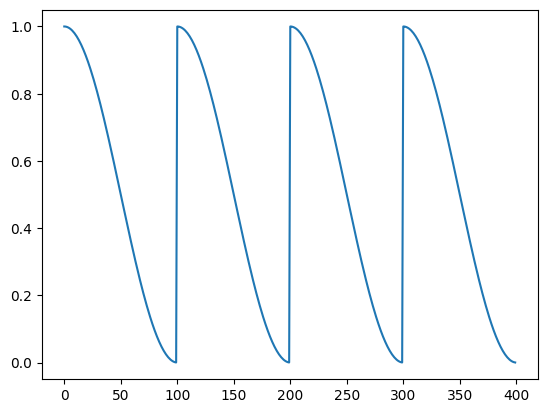

In [31]:
# визуализация изменения learning rate
n = 100
sched = cosine(n)
lrs = [sched(t, 1) for t in range(n * 4)]
plt.plot(lrs)

In [32]:
class RNNClassifier(nn.Module):
    """Simple implementation of RNN-based time-series classifier."""

    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.rnn = nn.RNN(input_dim, hidden_dim, layer_dim, batch_first=True)  # Замена LSTM на RNN
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.batch_size = None
        self.dropout = nn.Dropout(0.1)
        self.hidden = None

    def forward(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(x.device)
        out, hn = self.rnn(x, h0)
        out = self.dropout(out)
        out = self.fc(out[:, -1, :])
        return out

    def init_hidden(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(x.device)
        return h0.cuda()

In [33]:
print('Preparing datasets')
trn_ds, val_ds, enc = create_datasets(x_trn, y_trn['rating'])

Preparing datasets


In [34]:
bs = 16
print(f'Creating data loaders with batch size: {bs}')
trn_dl, val_dl = create_loaders(trn_ds, val_ds, bs, jobs=cpu_count())

Creating data loaders with batch size: 16


In [36]:
input_dim = 171  # размерность входная
hidden_dim = 8  # размерность скрытого пространства (ht)
layer_dim = 1  # кол-во скрытых слоев
output_dim = 8  # размерность выходная (количество признаков)
# seq_dim = 128    # длина последовательности

lr = 0.0005  # скорость обучения
n_epochs = 1000  # количество эпох
iterations_per_epoch = len(trn_dl)  # итераций в эпоху
best_acc = 0  # лучший accuracy
patience, trials = 200, 0  # сколько эпох держит без повышения accuracy, счетчик

# model = LSTMClassifier(input_dim, hidden_dim, layer_dim, output_dim)  # создаем класс LSTM
model = RNNClassifier(input_dim, hidden_dim, layer_dim, output_dim)  # создаем класс RNN

model = model.cuda()  # кидаем на CUDA
criterion = nn.CrossEntropyLoss()  # критерий (или функция потерь) для задач классификации
opt = torch.optim.RMSprop(model.parameters(), lr=lr)  # выбор оптимизатора
sched = CyclicLR(opt, cosine(t_max=iterations_per_epoch * 2, eta_min=lr / 100))

print('Start model training')

# Для каждой эпохи делаем
for epoch in range(1, n_epochs + 1):
    # Для счетчика, набора батчей в трейн дата лоадере
    for i, (x_batch, y_batch) in enumerate(trn_dl):
        model.train()  # перевод модели в режим обучения
        x_batch = x_batch.to(DEVICE)  # кидаем в CUDA
        y_batch = y_batch.to(DEVICE)  # кидаем в CUDA
        sched.step()  # обновление расписания scheduler для обновления скорости обучения
        opt.zero_grad()  # обнуление градиента
        out = model(x_batch)  # прямой проход по модели (на вход x_batch)
        loss = criterion(out, y_batch)  # смотрим чо по лоссу
        loss.backward()  # обратное распространение ошибки (вычисляем градиент по всем параметрам модели)
        opt.step()  # оптимизатором меняем веса для уменьшения функции потерь

    model.eval()  # перевод модели в режим оценки
    correct, total = 0, 0  # переменные правильно прдсказанные / всего

    # Для набора батчей в валидационном дата лоадере
    for x_val, y_val in val_dl:
        x_val, y_val = [t.to(DEVICE) for t in (x_val, y_val)]  # переносим все элементы в CUDA
        out = model(x_val)  # прямой проход по модели (на вход x_val)
        preds = F.log_softmax(out, dim=1).argmax(dim=1)  # логарифм от софтмакса и по нему максимальный
        total += y_val.size(0)  # увеличиваем тотал на батч у_вал
        correct += (preds == y_val).sum().item()  # увеличиваем коррект если правильно

    acc = correct / total  # метрика
    # Для каждой 5 эпохи
    if epoch % 5 == 0:
        print(f'Epoch: {epoch:3d}. Loss: {loss.item():.4f}. Acc.: {acc:2.2%}')
    # Если текущая метрика выше лучшей то обновляем лучшую
    if acc > best_acc:
        trials = 0
        best_acc = acc
        torch.save(model.state_dict(), 'best.pth')
        print(f'Epoch {epoch} best model saved with accuracy: {best_acc:2.2%}')
    else:
        trials += 1
        if trials >= patience:
            print(f'Early stopping on epoch {epoch}')
            break

# model.load_state_dict(torch.load('best.pth'))  # сохраненные параметры модели, полученные в процессе обучения

Start model training


C:\Users\mikhe\anaconda3\envs\gpu_env\Lib\site-packages\torch\optim\lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch 1 best model saved with accuracy: 29.23%
Epoch 3 best model saved with accuracy: 35.38%
Epoch 4 best model saved with accuracy: 38.46%
Epoch:   5. Loss: 2.3964. Acc.: 41.54%
Epoch 5 best model saved with accuracy: 41.54%
Epoch 7 best model saved with accuracy: 44.62%
Epoch 8 best model saved with accuracy: 46.15%
Epoch:  10. Loss: 1.5707. Acc.: 52.31%
Epoch 10 best model saved with accuracy: 52.31%
Epoch 11 best model saved with accuracy: 55.38%
Epoch:  15. Loss: 1.5490. Acc.: 60.00%
Epoch 15 best model saved with accuracy: 60.00%
Epoch 16 best model saved with accuracy: 61.54%
Epoch 17 best model saved with accuracy: 66.15%
Epoch:  20. Loss: 1.8765. Acc.: 64.62%
Epoch 21 best model saved with accuracy: 67.69%
Epoch 22 best model saved with accuracy: 69.23%
Epoch 23 best model saved with accuracy: 70.77%
Epoch:  25. Loss: 1.4637. Acc.: 72.31%
Epoch 25 best model saved with accuracy: 72.31%
Epoch 29 best model saved with accuracy: 73.85%
Epoch:  30. Loss: 1.0244. Acc.: 72.31%
Epoc

In [37]:
model.eval() # перевод модели в режим оценки
test_dl = DataLoader(create_test_dataset_fake(x_tst), batch_size=1, shuffle=False)
test = []
print('Predicting on test dataset')
for batch, _ in test_dl:
    batch = batch.permute(0, 2, 1)
    out = model(batch.cuda())
    y_hat = F.log_softmax(out, dim=1).argmax(dim=1)
    test += y_hat.tolist()
y_pred = enc.inverse_transform(test)
y_real = y_tst['rating'].values

correct, total = 0, 0 # переменные правильно прeдсказанные / всего
total = len(y_pred)
# Для набора батчей в валидационном дата лоадере
for i in range(len(y_pred)):
    if y_pred[i] == y_real[i]:
        correct += 1
acc = correct / total # метрика
print(f'Acc.: {acc:2.2%}')

# Рассчет квадратов разницы между предсказаниями и фактическими значениями
squared_diffs = (y_real - y_pred) ** 2

# Рассчет среднеквадратичного отклонения (RMSE)
rmse = torch.sqrt(torch.mean(torch.tensor(squared_diffs, dtype=torch.float32)))

print('RMSE:', rmse.item())

print(f'Predicted: {y_pred}')
print(f'Real     : {y_real}')

torch.cuda.empty_cache()

Predicting on test dataset
Acc.: 73.86%
RMSE: 0.94451904296875
Predicted: [11. 11. 11. 11. 11.  9.  9.  9. 10. 10. 11. 11. 11. 11. 11.  9.  9. 10.
 10. 10.  7.  7.  7.  7.  7.  8.  8.  8.  8.  8.  8.  7.  7.  7. 13. 13.
 13. 13. 13. 11. 11.  7.  7.  7.  7.  7. 12. 13. 13. 13. 13.  7.  7.  7.
  7.  7. 10. 10. 10. 10.  9.  9.  8.  8.  8.  8.  8. 10. 10. 10. 10. 10.
 10. 10. 10. 10. 10. 13. 13. 13. 13. 13. 13. 14. 14. 14. 14.  7.  7.  7.
  7.  7.  9.  9.  9.  9. 12. 12. 12. 12. 12.  9.  9.  9.  9.  9. 10. 10.
 10.  9.  9.  8.  8.  8.  8.  8.  8.  8.  8.  8. 13. 13. 13. 13. 13. 13.
 13. 13. 13. 10. 10. 10. 10. 10. 11. 13. 13. 13. 14. 14. 14. 14.  9.  9.
  9.  9.  9.  7.  7.  7. 11.  7.  7.  7.  9.  9.  9.  9.  9.  7.  7.  7.
  7. 14. 14. 14. 14. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11. 11.
 11. 11. 11. 11. 11. 11. 12. 12. 12. 13. 12. 11. 11. 11. 11. 11.  8.  8.
  8.  7.  7. 13. 13. 13. 13. 13. 11. 13. 13. 13.  9.  9.  9.  9. 11.  9.
  9.  9.  9.  9. 11. 11. 13. 11. 11. 13. 14. 14. 1

In [40]:
# возьмем одну строку (последнюю)
alone_str_ds = batch
out = model(alone_str_ds.cuda())
y_hat = F.log_softmax(out, dim=1).argmax(dim=1)
test = y_hat.tolist()

y_pred = enc.inverse_transform(test)
y_real = y_tst['rating'].values[-1]

print(f'Predicted: {y_pred}')
print(f'Real     : {y_real}')

torch.cuda.empty_cache()

Predicted: [14.]
Real     : 14.0


In [41]:
out

tensor([[-3.1398, -3.6614,  0.9272,  1.0740, -0.6378,  0.5458,  0.4957,  8.4233]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

## Делаем вручную проход модели

In [14]:
weights_path = 'best.pth'
model_weights = torch.load(weights_path)

In [17]:
# Извлечение весов RNN
rnn_ih = model_weights['rnn.weight_ih_l0']  # Входные веса
rnn_hh = model_weights['rnn.weight_hh_l0']  # Веса скрытого состояния
rnn_bias_ih = model_weights['rnn.bias_ih_l0']  # Входное смещение
rnn_bias_hh = model_weights['rnn.bias_hh_l0']  # Смещение скрытого состояния

# Извлечение весов выходного линейного слоя
fc_weight = model_weights['fc.weight']
fc_bias = model_weights['fc.bias']

rnn_ih, rnn_hh = rnn_ih.to(DEVICE), rnn_hh.to(DEVICE)
rnn_bias_ih, rnn_bias_hh = rnn_bias_ih.to(DEVICE), rnn_bias_hh.to(DEVICE)
fc_weight, fc_bias = fc_weight.to(DEVICE), fc_bias.to(DEVICE)

In [108]:
# # Входные данные
# input_data = alone_str_ds.to(DEVICE) # Входные данные

# # Инициализация скрытого состояния
# h_t = torch.zeros(layer_dim, input_data.size(0), hidden_dim).to(DEVICE)

# # RNN forward pass вручную
# x_t = input_data[:, 0, :] # берем вектор на шаге 0
# h_t = torch.tanh(torch.nn.functional.linear(x_t, rnn_ih, rnn_bias_ih) +
#                  torch.nn.functional.linear(h_t, rnn_hh, rnn_bias_hh))

# x_t = input_data[:, 1, :] # берем вектор на шаге 1
# h_t = torch.tanh(torch.nn.functional.linear(x_t, rnn_ih, rnn_bias_ih) +
#                  torch.nn.functional.linear(h_t, rnn_hh, rnn_bias_hh))

# x_t = input_data[:, 2, :] # берем вектор на шаге 2
# h_t = torch.tanh(torch.nn.functional.linear(x_t, rnn_ih, rnn_bias_ih) +
#                  torch.nn.functional.linear(h_t, rnn_hh, rnn_bias_hh))

# x_t = input_data[:, 3, :] # берем вектор на шаге 3
# h_t = torch.tanh(torch.nn.functional.linear(x_t, rnn_ih, rnn_bias_ih) +
#                  torch.nn.functional.linear(h_t, rnn_hh, rnn_bias_hh))

# # Выходной линейный слой
# output = torch.nn.functional.linear(h_t[-1], fc_weight, fc_bias)

# # Вывод предсказания
# print(output)

tensor([[ 0.1467, -2.8152,  0.6777, -1.5479,  0.8220, -0.0090,  1.2218,  4.3913]],
       device='cuda:0')


In [42]:
input_data = alone_str_ds.to(DEVICE) # Входные данные

# Инициализация скрытого состояния
h_t = torch.zeros(layer_dim, input_data.size(0), hidden_dim).to(DEVICE)

# RNN forward pass вручную
x_t = input_data[:, 0, :] # берем вектор на шаге 0
h_t = torch.tanh((torch.matmul(x_t, rnn_ih.t()) + rnn_bias_ih) + (torch.matmul(h_t, rnn_hh.t()) + rnn_bias_hh))

x_t = input_data[:, 1, :] # берем вектор на шаге 1
h_t = torch.tanh((torch.matmul(x_t, rnn_ih.t()) + rnn_bias_ih) + (torch.matmul(h_t, rnn_hh.t()) + rnn_bias_hh))

x_t = input_data[:, 2, :] # берем вектор на шаге 2
h_t = torch.tanh((torch.matmul(x_t, rnn_ih.t()) + rnn_bias_ih) + (torch.matmul(h_t, rnn_hh.t()) + rnn_bias_hh))

x_t = input_data[:, 3, :] # берем вектор на шаге 3
h_t = torch.tanh((torch.matmul(x_t, rnn_ih.t()) + rnn_bias_ih) + (torch.matmul(h_t, rnn_hh.t()) + rnn_bias_hh))

# Выходной линейный слой
output = torch.matmul(h_t[-1], fc_weight.t()) + fc_bias

# output = F.log_softmax(output, dim=1).argmax(dim=1).tolist()[0] + 7  # аргмакс 
# Вывод предсказания
print(output)

tensor([[-3.4352, -3.0381, -0.6374,  0.3247,  0.8955,  0.9448,  0.1575,  4.1821]],
       device='cuda:0')


In [18]:
fc_weight

tensor([[-0.6659, -0.2172, -0.6387,  0.8897,  0.5946, -0.4781, -0.5309,  0.5862],
        [-0.2825,  0.5308, -0.8168,  0.7818, -0.2230,  0.8097, -0.0630,  0.6541],
        [-0.7256,  0.6159,  1.1919, -0.5627, -0.6760,  0.5076, -0.6843,  0.7069],
        [-0.5396, -0.7187, -0.7301, -0.6844, -0.9063, -0.5834, -0.3702,  0.5613],
        [-0.5924, -0.5573, -0.5065, -0.6583,  0.8863, -0.5224, -0.0981, -0.9978],
        [ 0.3973, -0.3764,  0.4369,  0.3837,  0.5327, -0.5461,  0.6594,  0.3670],
        [ 0.4522,  1.0556,  0.3205,  0.7023,  0.4880,  0.7059,  0.8118, -0.9400],
        [ 0.6812, -0.7844,  0.3495, -0.1653, -0.8875, -0.2624,  0.7988, -0.4643]],
       device='cuda:0')

In [43]:
h_t

tensor([[[ 0.9972, -0.9677,  0.9949, -0.9889, -0.9362, -0.4871,  0.9991,
          -0.9790]]], device='cuda:0')

# Стресс тест

Берем какой-нибудь банк

In [291]:
resultDataSet = resultDataSet.sort_values(by='report_date')

In [292]:
resultDataSet

,1.1. Отношение кредитов к депозитам (LDR),1.2. Доля средств населения,1.3. Надежность банка,1.4. Норматив мгновенной ликвидности,1.5. Норматив текущей ликвидности,2.1. Достаточность собственных средств,2.2. Достаточность основного капитала,2.3. Устойчивость капитала,2.4. Доля основного капитала в общем капитале,3.1. ROE,...,Деловая репутация,Связанность операций с бизнесом,Отчетность МСФО,Рейтинги НРА,Количество рейтингов НРА (баллы),Прогноз по рейтингам НРА,External_rating,report_date,ПОДДЕРЖКА МАКСИМУМ,flag
Наименование показателя,,,,,,,,,,,,,,,,,,,,,
"АО ""Райффайзенбанк""",61.266786,38.801625,94.435332,59.378,84.236,7.970299,6.206465,99.609623,77.869920,0.461103,...,2,0,4,5.0,1.2,0.0,14,2022-03-01,20,main
"Банк ""ВБРР"" (АО)",35.013171,16.087175,83.492096,47.690,74.746,10.528078,9.709305,39.325650,92.222957,18.175796,...,1,2,4,5.0,1.2,0.0,13,2022-03-01,0,main
"КБ ""ЛОКО-Банк"" (АО)",68.311642,57.330220,215.824969,69.873,86.608,13.579617,11.670351,85.502127,85.940204,40.466037,...,1,0,4,4.0,1.0,0.0,10,2022-03-01,0,main
"АО Банк ""Национальный стандарт""",77.367699,43.519577,89.430876,49.223,125.798,23.860181,11.974733,37.553196,50.187101,0.180389,...,1,1,1,0.0,1.0,0.0,9,2022-03-01,10,main
"АО ""ТАТСОЦБАНК""",60.108718,24.065289,281.209883,65.667,106.885,30.642682,26.576535,78.241288,86.730446,18.916182,...,1,0,1,2.5,1.2,0.0,9,2022-03-01,0,main
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"ПАО ""МОСКОВСКИЙ КРЕДИТНЫЙ БАНК""",98.258722,17.671950,148.535890,63.391,59.243,6.879825,10.695100,-38.746899,155.455979,15.785074,...,2,1,0,5.0,2.0,1.2,12,2024-03-01,10,test
"АКБ ""СЛАВИЯ"" (АО)",34.288276,25.757412,287.971492,34.735,112.637,22.554817,37.318983,22.578820,165.459033,61.774823,...,1,0,0,2.5,1.0,0.0,7,2024-03-01,0,test
"ПАО ""МТС-Банк""",92.390414,49.382170,81.662166,43.466,76.718,12.372357,19.805846,-55.560104,160.081427,14.504742,...,1,1,0,5.0,2.0,1.2,11,2024-03-01,10,test


In [293]:
search_word = 'сов'
df_onebank = resultDataSet[resultDataSet.index.str.contains(search_word, case=False)]
df_onebank = df_onebank.iloc[-4:]
df_onebank

,1.1. Отношение кредитов к депозитам (LDR),1.2. Доля средств населения,1.3. Надежность банка,1.4. Норматив мгновенной ликвидности,1.5. Норматив текущей ликвидности,2.1. Достаточность собственных средств,2.2. Достаточность основного капитала,2.3. Устойчивость капитала,2.4. Доля основного капитала в общем капитале,3.1. ROE,...,Деловая репутация,Связанность операций с бизнесом,Отчетность МСФО,Рейтинги НРА,Количество рейтингов НРА (баллы),Прогноз по рейтингам НРА,External_rating,report_date,ПОДДЕРЖКА МАКСИМУМ,flag
Наименование показателя,,,,,,,,,,,,,,,,,,,,,
"ПАО ""Совкомбанк""",76.751546,29.741477,63.524153,36.118,77.105,7.673241,6.589492,55.007970,85.876248,34.543900,...,2,0,0,5.0,2.0,1.2,13,2023-12-01,10,test
"ПАО ""Совкомбанк""",74.209795,28.523594,79.660794,36.118,77.105,7.621273,6.622819,3.543839,86.899119,32.062040,...,2,0,0,5.0,2.0,1.2,13,2024-01-01,10,test
"ПАО ""Совкомбанк""",76.097977,28.483081,74.379933,38.170,81.674,7.627932,13.351346,-7.161161,175.032303,12.002274,...,2,0,0,5.0,2.0,1.2,13,2024-02-01,10,test
"ПАО ""Совкомбанк""",79.383267,28.272345,68.754638,57.309,81.674,7.595611,13.245688,-1.254153,174.386091,12.264985,...,2,0,0,5.0,2.0,1.2,13,2024-03-01,10,test


In [294]:
df_onebank

,1.1. Отношение кредитов к депозитам (LDR),1.2. Доля средств населения,1.3. Надежность банка,1.4. Норматив мгновенной ликвидности,1.5. Норматив текущей ликвидности,2.1. Достаточность собственных средств,2.2. Достаточность основного капитала,2.3. Устойчивость капитала,2.4. Доля основного капитала в общем капитале,3.1. ROE,...,Деловая репутация,Связанность операций с бизнесом,Отчетность МСФО,Рейтинги НРА,Количество рейтингов НРА (баллы),Прогноз по рейтингам НРА,External_rating,report_date,ПОДДЕРЖКА МАКСИМУМ,flag
Наименование показателя,,,,,,,,,,,,,,,,,,,,,
"ПАО ""Совкомбанк""",76.751546,29.741477,63.524153,36.118,77.105,7.673241,6.589492,55.007970,85.876248,34.543900,...,2,0,0,5.0,2.0,1.2,13,2023-12-01,10,test
"ПАО ""Совкомбанк""",74.209795,28.523594,79.660794,36.118,77.105,7.621273,6.622819,3.543839,86.899119,32.062040,...,2,0,0,5.0,2.0,1.2,13,2024-01-01,10,test
"ПАО ""Совкомбанк""",76.097977,28.483081,74.379933,38.170,81.674,7.627932,13.351346,-7.161161,175.032303,12.002274,...,2,0,0,5.0,2.0,1.2,13,2024-02-01,10,test
"ПАО ""Совкомбанк""",79.383267,28.272345,68.754638,57.309,81.674,7.595611,13.245688,-1.254153,174.386091,12.264985,...,2,0,0,5.0,2.0,1.2,13,2024-03-01,10,test


In [295]:
df_onebank.columns

Index(['1.1. Отношение кредитов к депозитам (LDR)',
       '1.2. Доля средств населения', '1.3. Надежность банка',
       '1.4. Норматив мгновенной ликвидности',
       '1.5. Норматив текущей ликвидности',
       '2.1. Достаточность собственных средств',
       '2.2. Достаточность основного капитала', '2.3. Устойчивость капитала',
       '2.4. Доля основного капитала в общем капитале', '3.1. ROE', '3.2. ROA',
       '4.1. Коэффициент процентных доходов',
       '4.2. Коэффициент процентных расходов',
       '4.3. Доля операционных расходов в доходах', '5.1. Прирост кредитов',
       '5.2. Уровень просроченной задолженности',
       '5.3. Отношение NPL к Капиталу  (1.2)',
       '5.4. Коэффициент резервирования', '5.5. Стоимость риска', 'Доля рынка',
       'Стабильность доли рынка', 'Отклонение темпов роста',
       'Диверсификация дохода', 'География присутствия',
       'Структура собственности', 'Доля государства', 'Частные акционеры',
       'Качество управления', 'Деловая репутаци

In [296]:
df_onebank['5.5. Стоимость риска']

Наименование показателя
ПАО "Совкомбанк"    4.884002
ПАО "Совкомбанк"    4.757939
ПАО "Совкомбанк"    4.757939
ПАО "Совкомбанк"    4.757939
Name: 5.5. Стоимость риска, dtype: float64

## Изменение определенных столбцов

In [297]:
df_onebank['Отклонение темпов роста'] = [3.0, 2.0, 1.0, 0.0]
df_onebank['Отклонение темпов роста'] = pd.Categorical(df_onebank['Отклонение темпов роста'], categories=[0,0.5,1,1.5,2,2.5,3])

In [298]:
# Определяем столбец для изменения
column_to_increase = '1.1. Отношение кредитов к депозитам (LDR)'
# Задаем начальный и конечный множители
start_factor = 1.0  # 100%
end_factor = 100   # 
# Создаем линейно возрастающий коэффициент
factors = np.linspace(start_factor, end_factor, len(df_onebank))
# Применяем эти коэффициенты к столбцу
df_onebank[column_to_increase] = df_onebank[column_to_increase].iloc[0]
df_onebank[column_to_increase] = df_onebank[column_to_increase] * factors

# Определяем столбец для изменения
column_to_increase = '4.2. Коэффициент процентных расходов'
# Задаем начальный и конечный множители
start_factor = 1  # 100%
end_factor = 0.65  # 
# Создаем линейно возрастающий коэффициент
factors = np.linspace(start_factor, end_factor, len(df_onebank))
# Применяем эти коэффициенты к столбцу
df_onebank[column_to_increase] = df_onebank[column_to_increase].iloc[0]
df_onebank[column_to_increase] = df_onebank[column_to_increase] * factors

# Определяем столбец для изменения
column_to_increase = '4.1. Коэффициент процентных доходов'
# Задаем начальный и конечный множители
start_factor = 1  # 100%
end_factor = 0.42  # 
# Создаем линейно возрастающий коэффициент
factors = np.linspace(start_factor, end_factor, len(df_onebank))
# Применяем эти коэффициенты к столбцу
df_onebank[column_to_increase] = df_onebank[column_to_increase].iloc[0]
df_onebank[column_to_increase] = df_onebank[column_to_increase] * factors

# Определяем столбец для изменения
column_to_increase = '5.1. Прирост кредитов'
# Задаем начальный и конечный множители
start_factor = 1  # 100%
end_factor = 0  # 
# Создаем линейно возрастающий коэффициент
factors = np.linspace(start_factor, end_factor, len(df_onebank))
# Применяем эти коэффициенты к столбцу
df_onebank[column_to_increase] = df_onebank[column_to_increase].iloc[0]
df_onebank[column_to_increase] = df_onebank[column_to_increase] * factors

# Определяем столбец для изменения
column_to_increase = '5.2. Уровень просроченной задолженности'
# Задаем начальный и конечный множители
start_factor = 1  # 100%
end_factor = 1.18  # 
# Создаем линейно возрастающий коэффициент
factors = np.linspace(start_factor, end_factor, len(df_onebank))
# Применяем эти коэффициенты к столбцу
df_onebank[column_to_increase] = df_onebank[column_to_increase].iloc[0]
df_onebank[column_to_increase] = df_onebank[column_to_increase] * factors

# Определяем столбец для изменения
column_to_increase = '5.4. Коэффициент резервирования'
# Задаем начальный и конечный множители
start_factor = 1  # 100%
end_factor = 1.21  # 
# Создаем линейно возрастающий коэффициент
factors = np.linspace(start_factor, end_factor, len(df_onebank))
# Применяем эти коэффициенты к столбцу
df_onebank[column_to_increase] = df_onebank[column_to_increase].iloc[0]
df_onebank[column_to_increase] = df_onebank[column_to_increase] * factors

# Определяем столбец для изменения
column_to_increase = '5.3. Отношение NPL к Капиталу  (1.2)'
# Задаем начальный и конечный множители
start_factor = 1  # 100%
end_factor = 0.85  # 
# Создаем линейно возрастающий коэффициент
factors = np.linspace(start_factor, end_factor, len(df_onebank))
# Применяем эти коэффициенты к столбцу
df_onebank[column_to_increase] = df_onebank[column_to_increase].iloc[0]
df_onebank[column_to_increase] = df_onebank[column_to_increase] * factors

# Определяем столбец для изменения
column_to_increase = '5.5. Стоимость риска'
# Задаем начальный и конечный множители
start_factor = 1  # 100%
end_factor = 0.87  # 
# Создаем линейно возрастающий коэффициент
factors = np.linspace(start_factor, end_factor, len(df_onebank))
# Применяем эти коэффициенты к столбцу
df_onebank[column_to_increase] = df_onebank[column_to_increase].iloc[0]
df_onebank[column_to_increase] = df_onebank[column_to_increase] * factors

In [299]:
df_category = pd.get_dummies(df_onebank, columns=['Доля рынка', 'Стабильность доли рынка', 'Отклонение темпов роста',
                                                     'Диверсификация дохода', 'География присутствия',
                                                     'Структура собственности', 'Доля государства', 'Частные акционеры', 'Качество управления', 'Деловая репутация', 'Связанность операций с бизнесом', 
                                                     'Отчетность МСФО', 
                                                     'Рейтинги НРА', 'Количество рейтингов НРА (баллы)', "Прогноз по рейтингам НРА", 
                                                     'ПОДДЕРЖКА МАКСИМУМ'], dtype=int)

In [300]:
## ФОНДИРОВАНИЕ И ЛИКВИДНОСТЬ (МАКС 11 Б.)

# 1.1 LDR
bins_LDR = [-np.inf, 75, 90, 105, 120, np.inf]
df_category = category_bins(df_category, '1.1. Отношение кредитов к депозитам (LDR)', bins_LDR, 'LDR')

# 1.2 Доля средств населения в обязательствах
bins_Population = [-np.inf, 10, 20, 30, 40, np.inf]
df_category = category_bins(df_category, '1.2. Доля средств населения', bins_Population, 'Population')

# 1.3 Надежность банка
bins_Safety = [-np.inf, 80, 100, 105, 110, np.inf] 
df_category = category_bins(df_category, '1.3. Надежность банка', bins_Safety, 'Safety')

# 1.4 Норматив мгновенной ликвидности (Н2)
bins_InstantLiquidity = [-np.inf, 20, 25, 35, 50, np.inf] 
df_category = category_bins(df_category, '1.4. Норматив мгновенной ликвидности', bins_InstantLiquidity, 'InstantLiquidity')

# 1.5 Норматив текущей ликвидности (Н3)
bins_CurrentLiquidity = [-np.inf, 55, 60, 75, 100, np.inf] 
df_category = category_bins(df_category, '1.5. Норматив текущей ликвидности', bins_CurrentLiquidity, 'CurrentLiquidity')

## ДОСТАТОЧНОСТЬ КАПИТАЛА (МАКС 15 Б.)

# 2.1 Коэффициент достаточности собственных средств (капитала) банка (Total capital ratio)
bins_TCR = [-np.inf, 10.5, 12, 14, 16, np.inf] 
df_category = category_bins(df_category, '2.1. Достаточность собственных средств', bins_TCR, 'TCR(Кэф дост СС)')

# 2.2 Коэффициент достаточности основного капитала
bins_CAP = [-np.inf, 8, 9, 11, 14, np.inf] 
df_category = category_bins(df_category, '2.2. Достаточность основного капитала', bins_CAP, 'CAP(Кэф дост OK)')

# 2.3 Коэффициент устойчивости капитала (CS)
bins_CS = [-np.inf, -45, -25, 25, 45, np.inf] 
df_category = category_bins(df_category, '2.3. Устойчивость капитала', bins_CS, 'CS(Уст капитала)')

# 2.4 Доля основного капитала в общем капитале
bins_PartCap = [-np.inf, 60, 70, 80, 90, np.inf] 
df_category = category_bins(df_category, '2.4. Доля основного капитала в общем капитале', bins_PartCap, 'Доля осн кап')

## РЕНТАБЕЛЬНОСТЬ (МАКС 4 Б.)

# 3.1 ROE
bins_ROE = [-np.inf, 0, 5, 10, 15, np.inf] 
df_category = category_bins(df_category, '3.1. ROE', bins_ROE, 'ROE')

# 3.2 ROA
bins_ROA = [-np.inf, 0, 0.3, 1, 3, np.inf] 
df_category = category_bins(df_category, '3.2. ROA', bins_ROA, 'ROA')

## ОПЕР ЭФФЕКТИВНОСТЬ (МАКС 8 Б.)

# 4.1 Коэффициент процентных доходов (K_I)
bins_KI = [-np.inf, 4, 6, 8, 10, np.inf] 
df_category = category_bins(df_category, '4.1. Коэффициент процентных доходов', bins_KI, 'Кэф проц доходов')

# 4.2 Коэффициент процентных расходов (K_E)
bins_KE = [-np.inf, 2, 4, 6, 8, np.inf] 
df_category = category_bins(df_category, '4.2. Коэффициент процентных расходов', bins_KE, 'Кэф проц расходов')

# 4.3 Доля операционных расходов в доходах (CTI)
bins_CTI = [-np.inf, 50, 60, 75, np.inf] 
df_category = category_bins(df_category, '4.3. Доля операционных расходов в доходах', bins_CTI, 'Доля операционных расходов')

## КАЧЕСТВО АКТИВОВ (МАКС 12 Б.)

# 5.1 Прирост совокупных кредитов (∆_L)
bins_DeltaL = [-np.inf, 0, 1, 2, 3, np.inf] 
df_category = category_bins(df_category, '5.1. Прирост кредитов', bins_DeltaL, 'Прирост кредитов')
 
# 5.2 Уровень просроченной задолженности (NPL_L)
bins_NPLL = [-np.inf, 3, 5, 7, 10, np.inf] 
df_category = category_bins(df_category, '5.2. Уровень просроченной задолженности', bins_NPLL, 'Уровень проср задолж')

# 5.3 Отношение проблемной задолженности к основному капиталу (NPL_C)
bins_NPLC = [-np.inf, 10, 20, 30, 50, np.inf]
df_category = category_bins(df_category, '5.3. Отношение NPL к Капиталу  (1.2)', bins_NPLC, 'Отношение NPL к Капиталу')

# 5.4 Коэффициент резервирования (K_R)
bins_KR = [-np.inf, 3, 5, 7, 10, np.inf]
df_category = category_bins(df_category, '5.4. Коэффициент резервирования', bins_KR, 'Кэф резервирования')

# 5.5 Стоимость риска (CoR)
bins_CoR = [-np.inf, 1.5, 3, 5, 7, np.inf]
df_category = category_bins(df_category, '5.5. Стоимость риска', bins_CoR, 'Стоимость риска')

In [301]:
rating = df_category.iloc[-1]['External_rating']
df_cat_drop = df_category.drop("External_rating", axis = 1) 
df_cat_drop = df_cat_drop.drop("report_date", axis = 1) 
df_cat_drop = df_cat_drop.drop("flag", axis=1)

## Предикт

In [302]:
df_one_np = df_cat_drop.values
alone_str_ds = torch.tensor(df_one_np.reshape(1, 4, 171), dtype=torch.float32)

In [303]:
weights_path = 'best.pth'
model_weights = torch.load(weights_path)

In [304]:
# Извлечение весов RNN
rnn_ih = model_weights['rnn.weight_ih_l0']  # Входные веса
rnn_hh = model_weights['rnn.weight_hh_l0']  # Веса скрытого состояния
rnn_bias_ih = model_weights['rnn.bias_ih_l0']  # Входное смещение
rnn_bias_hh = model_weights['rnn.bias_hh_l0']  # Смещение скрытого состояния

# Извлечение весов выходного линейного слоя
fc_weight = model_weights['fc.weight']
fc_bias = model_weights['fc.bias']

rnn_ih, rnn_hh = rnn_ih.to(DEVICE), rnn_hh.to(DEVICE)
rnn_bias_ih, rnn_bias_hh = rnn_bias_ih.to(DEVICE), rnn_bias_hh.to(DEVICE)
fc_weight, fc_bias = fc_weight.to(DEVICE), fc_bias.to(DEVICE)

In [305]:
input_data = alone_str_ds.to(DEVICE) # Входные данные

# Инициализация скрытого состояния
h_t = torch.zeros(layer_dim, input_data.size(0), hidden_dim).to(DEVICE)

# RNN forward pass вручную
x_t = input_data[:, 0, :] # берем вектор на шаге 0
h_t = torch.tanh((torch.matmul(x_t, rnn_ih.t()) + rnn_bias_ih) + (torch.matmul(h_t, rnn_hh.t()) + rnn_bias_hh))

x_t = input_data[:, 1, :] # берем вектор на шаге 1
h_t = torch.tanh((torch.matmul(x_t, rnn_ih.t()) + rnn_bias_ih) + (torch.matmul(h_t, rnn_hh.t()) + rnn_bias_hh))

x_t = input_data[:, 2, :] # берем вектор на шаге 2
h_t = torch.tanh((torch.matmul(x_t, rnn_ih.t()) + rnn_bias_ih) + (torch.matmul(h_t, rnn_hh.t()) + rnn_bias_hh))

x_t = input_data[:, 3, :] # берем вектор на шаге 3
h_t = torch.tanh((torch.matmul(x_t, rnn_ih.t()) + rnn_bias_ih) + (torch.matmul(h_t, rnn_hh.t()) + rnn_bias_hh))

# Выходной линейный слой
output = torch.matmul(h_t[-1], fc_weight.t()) + fc_bias

# output = F.log_softmax(output, dim=1).argmax(dim=1).tolist()[0] + 7  # аргмакс 
# Вывод предсказания
print(output)

tensor([[-2.6131, -5.0185,  0.2409, -0.4760,  0.9283,  0.2042,  5.7615, -0.6727]],
       device='cuda:0')


In [306]:
rating

13

In [307]:
(torch.matmul(x_t, rnn_ih.t()) + rnn_bias_ih) + (torch.matmul(h_t, rnn_hh.t()) + rnn_bias_hh)

tensor([[[-3.7979, -3.3985,  1.8154, -2.3935, -4.3890, -2.8751,  2.5753,
          -0.7016]]], device='cuda:0')

In [308]:
torch.matmul((torch.matmul(x_t, rnn_ih.t()) + rnn_bias_ih) + (torch.matmul(h_t, rnn_hh.t()) + rnn_bias_hh), fc_weight.t()) + fc_bias

tensor([[[ -8.7063, -15.1671,  -0.4771,  -1.6823,   2.9234,   1.4592,  17.2992,
            1.0264]]], device='cuda:0')

# Кульбака с разделением и прошлыми значениями

In [3]:
x_trn = pd.read_csv('X_train_quad.csv')
x_tst = pd.read_csv('X_test_quad.csv')
y_trn = pd.read_csv('y_train_quad.csv')
y_tst = pd.read_csv('y_test_quad.csv')
ID_COLS = ['series_id', 'index_bank']

In [4]:
def create_grouped_array(data, group_col='series_id', drop_cols=ID_COLS):
    X_grouped = np.row_stack([
        group.drop(columns=drop_cols).values[None]
        for _, group in data.groupby(group_col)])
    return X_grouped

def xavier_normal_vector(input, output):
    std = np.sqrt(2 / (input + output))
    return np.random.normal(0, std, input)

# def softmax(x):
#     exp_values = np.exp(x - np.max(x, axis=-1, keepdims=True))
#     return exp_values / np.sum(exp_values, axis=-1, keepdims=True)

def softmax(x):
    # Вычитаем максимальное значение из x для числовой стабильности
    x_max = np.max(x)
    e_x = np.exp(x - x_max)
    return e_x / e_x.sum(axis=0)

def stable_softmax(x):
    # Находим минимальное значение вектора
    min_value = np.min(x)
    # Если минимальное значение отрицательное, прибавляем его абсолютное значение плюс небольшую константу
    if min_value <= 0:
        x = x + abs(min_value) + 1e-6

    x_sum = np.sum(x)
    return (x / x_sum)

In [5]:
stable_softmax([10000, 10000, 100])

array([0.49751244, 0.49751244, 0.00497512])

In [6]:
x_trn_grouped = create_grouped_array(x_trn)

# 8 классов 
class_external = np.array([7, 8, 9, 10, 11, 12, 13, 14])

# Переводим external rating в бальный рейтинг
replacement_dict = {
    7: 40,
    8: 50,
    9: 56,
    10: 64,
    11: 74,
    12: 85,
    13: 92,
    14: 97
}
# y_trn_grouped = y_trn['rating'].replace(replacement_dict).values
y_trn_grouped = y_trn['rating'].values

## Функция минимизации

In [7]:
# Функция для minimize 
def funcn(ww):
    ww = ww.reshape(-1, 1)
    # y_pred = np.dot(df_train, ww)
    # Кульбак
    kl = np.empty(0)
    # Бизнес колонки
    x_business = x_trn_grouped[:, :, :77]
    # Финанс колонки
    x_finance = x_trn_grouped[:, :, 77:]
    # Бизнес веса с хидден дим для бизнеса
    w_business = ww[:78]
    # Финанс веса с хидден дим для финанса
    w_finance = ww[78:173]
    # Альфы для перемножения
    alpha = ww[173:]
    alpha =  np.split(alpha, 8)
    for i in range(len(y_trn_grouped)):
        # h_bus = np.random.normal(loc=0, scale=1)
        h_bus = 1
        # h_fin = np.random.normal(loc=0, scale=1)
        h_fin = 1
        for j in range(4):            
            x_bus = np.append(x_business[i][j], h_bus)           
            x_fin = np.append(x_finance[i][j], h_fin)           
            h_bus = np.dot(x_bus, w_business)
            h_fin = np.dot(x_fin, w_finance)
        # x_bus = np.append(x_business[i][0], h_bus)           
        # x_fin = np.append(x_finance[i][0], h_fin)
        # h_bus = np.dot(x_bus, w_business)
        # h_fin = np.dot(x_fin, w_finance)
        
        h = np.concatenate((h_bus, h_fin))
        # Перемножение h на веса альфа для получения вектора из 8 элементов
        y_pred_arr = np.array([h[0] * pair[0] + h[1] * pair[1] for pair in alpha])        
        y_pred_arr = stable_softmax(y_pred_arr)
        y_pred_arr = y_pred_arr + 0.00001
        
        # создаем массив нулей
        class_zeros = np.zeros(len(class_external))

        # делаем столбец
        class_zeros = class_zeros.reshape(-1, 1)

        # кидаем 1 к какому относится class_external = np.array([40, 50, 56, 64, 74, 85, 92, 97])
        class_zeros[np.where(class_external == y_trn_grouped[i])] = 1
        class_zeros = class_zeros + 0.00001

        # Кульбака Лейбнера
        kli = kl_div(class_zeros, y_pred_arr).sum()
        kl = np.append(kl, kli)
        # Проверка kl на NaN или бесконечность
        
        ##ШТРАФНАЯ ФУНКЦИЯ
    if np.any(np.isnan(kl)) or np.any(np.isinf(kl)):
        print(f"Invalid KL divergence at i={i}")
        return np.inf    
    kl_sum = kl.sum()
    return kl_sum

In [8]:
# функция миниммизации выдает балл
# cons = ({'type': 'ineq', 'fun': h})
# bounds = [(0, 1), (0, 1), (0, 1), (0, 1)]
# Начальный вектор весов с помощью Ксавьера
# веса(кэфы), бизнес первые 5 строк, 6 строка поддержка, 5 последние строк финансовые
w =    [0,0.5,1,2,3,4,5, 0,0.5,1,1.2,1.5,1.8,2, 0,0.5,1,1.5,2,2.5,3, # стабильность бизнеса
        0,0.6,1.2,1.8,2.4,3,  0,1,2,3,4, # диверсификация
        -1,1,2, 0,1,2,3,4,5, 0,1,2,3, -3,-1.5,0,1.5,3, -1,0,1,2, 0,1,2,# корпоративное управление и репа
        0,1,2,3,4, # отчетность МСФО
        0,2.5,4,5, 1,1.2,2, 0,1.2,2,# рейтинги
        0,8,10,16,20, # макс поддержка (15 б)
        # фин (45 б)
        1,2,1,0,-1, -1,0,2,0,-1, -1,0,1,2,4, -0.5,0,0.5,1,1.5, -0.5,0,0.5,1,1.5, 
       -1,0,1,2,4, -1,0,1,2,4, -2,-1,1,2,4, -1.5,0,0.75,1.5,3,
       -1,0,1,1.5,2, -1,0,1,1.5,2,
       -1,0,1,1.7,2.5, 2.5,1.7,1,0,-1, 3,1.5,0,-1.5,
       -0.5,0,0.5,1,2, 3,1.5,1,0,-1, 2,1,0,-0.5,-1, 3,2,1,0,-1, 2,1.3,0.6,0,-1.3]
w = np.asarray(w)
# Хидден дим начальные
w = np.insert(w, 77, random.randint(40, 99))
w = np.append(w, random.randint(40, 99))

# Альфы для перемножения 2х элементов хидден дим на альфа, чтобы получить вектор из 8 элементов
w_xavier = xavier_normal_vector(16, 8)
w_xavier = np.maximum(w_xavier, 0.0)
w_xavier += 0.01
w = np.append(w, w_xavier)

In [9]:
# Функция ограничения
def h(ww):
    # Ограничение бизнес признаков <= 47
    wl = -(ww[:72].sum() - 47)
    # Ограничение макс поддержки признаков <= 15
    wc = -(ww[72:77].sum() - 15)
    # Ограничение финанс признаков <= 50
    wp = -(ww[77:].sum() - 50)
    
    # # Ограничение (доля рынка-отклонение темпов роста) 10 баллов
    # wb1 = -(ww[:21].sum() - 10)
    # # Ограничение (диверсификация-география) 7 баллов 
    # wb2 = -(ww[21:32].sum() - 7)
    # # Ограничение (структура собств-связанность оп с кр бизнесом) 17 баллов
    # wb3 = -(ww[32:57].sum() - 17)
    # # Ограничение (отчетность МСФО) 4 балла
    # wb4 = -(ww[57:62].sum() - 4)
    # # Ограничение (рейтинги) 9 баллов
    # wb5 = -(ww[62:72].sum() - 9)
    
    # # Ограничение (LDR-CurrentLiquidity) 11 баллов
    # wf1 = -(ww[77:102].sum() - 11)
    # # Ограничение (TCR-Доля осн кап) 15 баллов
    # wf2 = -(ww[102:122].sum() - 15)
    # # Ограничение (ROE-ROA) 4 балла
    # wf3 = -(ww[122:132].sum() - 4)
    # # Ограничение (Кэф проц доходов-Доля операционных расходов) 8 баллов
    # wf4 = -(ww[132:146].sum() - 8)
    # # Ограничение ('Прирост кредитов-Стоимость риска) 12 баллов
    # wf5 = -(ww[146:].sum() - 12)
    
    return wl, wc, wp
    # , wb1, wb2, wb3, wb4, wb5, wf1, wf2, wf3, wf4, wf5

In [ ]:
# функция миниммизации выдает балл
cons = ({'type': 'ineq', 'fun': h})
resg = spop.minimize(funcn, w, options={'disp': True})

In [ ]:
weight = resg.x.reshape(-1, 1)
np.savetxt('weights_rnn_kul.csv', weight)

## Оценка результатов

In [36]:
weight = pd.read_csv('weights_rnn_kul.csv', header=None)
weight = weight.values.reshape(-1, 1)
x_business = x_trn_grouped[:, :, :77]
x_finance = x_trn_grouped[:, :, 77:]
w_business = weight[:78]
w_finance = weight[78:173]
alpha = weight[173:]
alpha =  np.split(alpha, 8)
y_pred = np.empty(0)

for i in range(len(y_trn_grouped)):
        h_bus = 1
        h_fin = 1
        for j in range(4):            
            x_bus = np.append(x_business[i][j], h_bus)           
            x_fin = np.append(x_finance[i][j], h_fin)
            
            h_bus = np.dot(x_bus, w_business)
            h_fin = np.dot(x_fin, w_finance)
            
        h = np.concatenate((h_bus, h_fin))
        # Перемножение h на веса альфа для получения вектора из 8 элементов
        y_pred_arr = np.array([h[0] * pair[0] + h[1] * pair[1] for pair in alpha])
        y_pred_arr = stable_softmax(y_pred_arr)
        y_pred = np.append(y_pred, y_pred_arr.argmax()+7)
y_pred

array([10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
       10., 11., 11., 11., 11., 11., 11., 10., 10., 11., 11., 11., 11.,
       11., 11., 11., 10., 11., 11., 11., 11., 11., 11., 10., 11., 11.,
       11., 11., 11., 11., 11., 14., 11., 11., 11., 11., 11., 14

In [15]:
y_real = y_trn_grouped
correct, total = 0, 0 # переменные правильно прeдсказанные / всего
total = len(y_pred)
# Для набора батчей в валидационном дата лоадере
for i in range(len(y_pred)):
    if y_pred[i] == y_real[i]:
        correct += 1
acc = correct / total # метрика
print(f'Acc.: {acc:2.2%}')

# Рассчет квадратов разницы между предсказаниями и фактическими значениями
squared_diffs = (y_real - y_pred) ** 2

# Рассчет среднеквадратичного отклонения (RMSE)
rmse = np.sqrt(np.mean(squared_diffs))

print('RMSE:', rmse.item())


Acc.: 32.99%
RMSE: 1.62553410026093


## Эксперимент для каждого контрагента 1 четверка

In [19]:
x_trn_alone = pd.read_csv('X_train_quad.csv')

In [23]:
x_trn_alone = x_trn_alone.groupby('index_bank').head(4)
x_trn_alone.reset_index(drop=True, inplace=True)

In [27]:
x_trn_grouped = create_grouped_array(x_trn_alone)

In [32]:
y_trn_alone = pd.read_csv('y_train_quad.csv')

In [36]:
y_trn_alone = y_trn_alone.groupby('index_bank').head(1)
y_trn_alone.reset_index(drop=True, inplace=True)

In [39]:
y_trn_grouped =  y_trn_alone['rating'].values

In [62]:
np.unique(y_trn_grouped, return_counts=True)

(array([ 7.,  8.,  9., 10., 11., 12., 13., 14.]),
 array([ 54,  55, 117,  82, 132,  36, 112,  54], dtype=int64))

## Андерсэмплинг

In [30]:
# СЛИШКОМ МНОГО 9, 11, 13. ИЗМЕНИМ СООТНОШЕНИЕ В ТРЕЙНЕ
print("До андерсэмплинга:")
unique, counts = np.unique(y_trn_grouped, return_counts=True)
print(dict(zip(unique, counts)))

До андерсэмплинга:
{7.0: 36, 8.0: 36, 9.0: 36, 10.0: 36, 11.0: 36, 12.0: 36, 13.0: 36, 14.0: 36}


In [31]:
# Определение количества образцов в каждом классе
unique, counts = np.unique(y_trn_grouped, return_counts=True)
class_counts = dict(zip(unique, counts))

# Минимальное количество образцов среди классов
min_count = min(class_counts.values())

# Списки для хранения новых данных
X_resampled = []
y_resampled = []
index_array = []

# Выполнение андерсэмплинга
for class_value in class_counts:
    # Выбор индексов текущего класса
    class_indices = np.where(y_trn_grouped == class_value)[0]
    
    # Выбор случайного подмножества до min_count
    selected_indices = np.random.choice(class_indices, size=min_count, replace=False)
    
    # Добавление выбранных индексов в результирующие списки
    X_resampled.append(x_trn_grouped[selected_indices])
    y_resampled.append(y_trn_grouped[selected_indices])
    index_array = np.append(index_array, selected_indices)

# Объединение всех классов
X_resampled = np.vstack(X_resampled)
y_resampled = np.hstack(y_resampled)

print("После андерсэмплинга:")
unique, counts = np.unique(y_resampled, return_counts=True)
print(dict(zip(unique, counts)))

После андерсэмплинга:
{7.0: 36, 8.0: 36, 9.0: 36, 10.0: 36, 11.0: 36, 12.0: 36, 13.0: 36, 14.0: 36}


In [32]:
x_trn_grouped = X_resampled
y_trn_grouped = y_resampled

In [10]:
unique, counts = np.unique(y_trn.loc[index_array]['index_bank'], return_counts=True)
print(dict(zip(unique, counts)))

{'"Азиатско-Тихоокеанский Банк" (ПАО)': 6, '"Банк "МБА-МОСКВА" ООО': 3, 'АКБ "Абсолют Банк" (ПАО)': 5, 'АКБ "Держава" ПАО': 2, 'АКБ "Ланта-Банк" (АО)': 8, 'АКБ "НРБанк" (АО)': 10, 'АО "АЛЬФА-БАНК"': 3, 'АО "БКС Банк"': 2, 'АО "БайкалИнвестБанк"': 9, 'АО "Банк ДОМ.РФ"': 1, 'АО "Банк Русский Стандарт"': 7, 'АО "Банк ФИНАМ"': 1, 'АО "Банк Финсервис"': 4, 'АО "Денизбанк Москва"': 2, 'АО "КОШЕЛЕВ-БАНК"': 9, 'АО "Кредит Европа Банк (Россия)"': 6, 'АО "МСП Банк"': 4, 'АО "ОТП Банк"': 14, 'АО "Райффайзенбанк"': 9, 'АО "Россельхозбанк"': 4, 'АО "Солид Банк"': 12, 'АО "ТАТСОЦБАНК"': 2, 'АО АКБ "НОВИКОМБАНК"': 8, 'АО Банк "Национальный стандарт"': 3, 'АО КБ "Солидарность"': 8, 'АО РОСЭКСИМБАНК': 5, 'Азия-Инвест Банк (АО)': 3, 'АйСиБиСи Банк (АО)': 3, 'Банк "ВБРР" (АО)': 5, 'Банк ГПБ (АО)': 3, 'КБ "Кубань Кредит" ООО': 4, 'КБ "ЛОКО-Банк" (АО)': 8, 'КБ "Москоммерцбанк" (АО)': 9, 'КБ "ЭНЕРГОТРАНСБАНК" (АО)': 5, 'КИВИ Банк (АО)': 6, 'НКО НКЦ (АО)': 10, 'ООО "ХКФ Банк"': 6, 'ООО "Экспобанк"': 4, 'ООО 

## График реальных и предсказанных

In [20]:
df_predict = pd.DataFrame()
df_predict['index_bank'] = y_trn.loc[index_array]['index_bank']

df_predict['true_rate'] = y_resampled
df_predict['predict_rate'] = y_pred

In [21]:
df_predict.sort_values('index_bank')

,index_bank,true_rate,predict_rate
3,"""Азиатско-Тихоокеанский Банк"" (ПАО)",9.0,11.0
4,"""Азиатско-Тихоокеанский Банк"" (ПАО)",9.0,11.0
9,"""Азиатско-Тихоокеанский Банк"" (ПАО)",10.0,11.0
6,"""Азиатско-Тихоокеанский Банк"" (ПАО)",10.0,11.0
7,"""Азиатско-Тихоокеанский Банк"" (ПАО)",10.0,11.0
...,...,...,...
632,ПАО Сбербанк,14.0,14.0
636,ПАО Сбербанк,14.0,14.0
638,ПАО Сбербанк,14.0,14.0
641,ПАО Сбербанк,14.0,14.0


In [23]:
df_predict.loc[df_predict['index_bank'] == 'АО КБ "Солидарность"']

,index_bank,true_rate,predict_rate
278,"АО КБ ""Солидарность""",8.0,8.0
283,"АО КБ ""Солидарность""",8.0,8.0
284,"АО КБ ""Солидарность""",8.0,8.0
275,"АО КБ ""Солидарность""",8.0,8.0
277,"АО КБ ""Солидарность""",8.0,8.0
285,"АО КБ ""Солидарность""",8.0,8.0
280,"АО КБ ""Солидарность""",8.0,8.0
288,"АО КБ ""Солидарность""",8.0,8.0


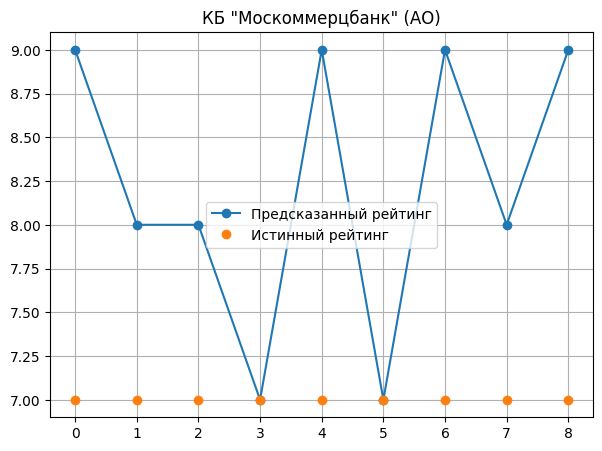

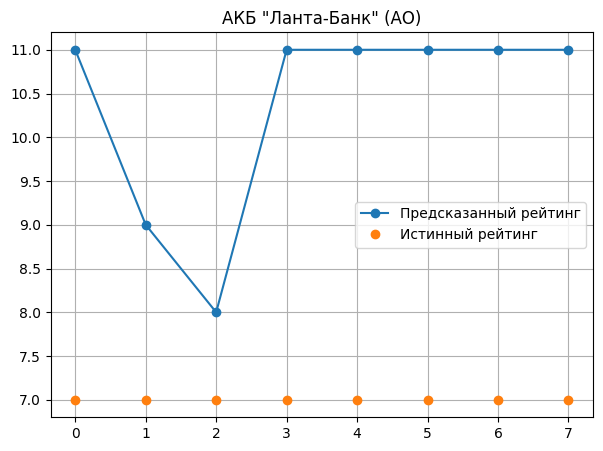

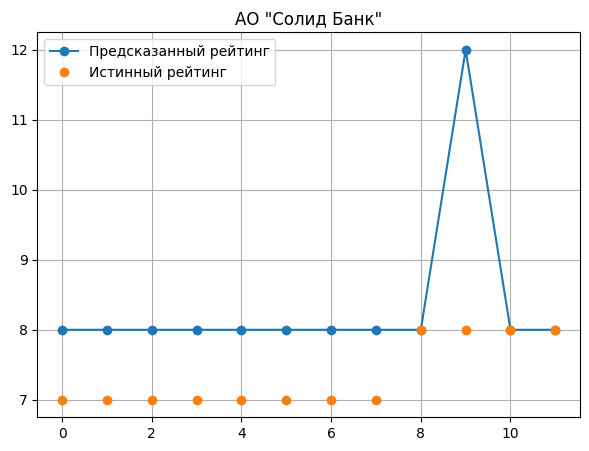

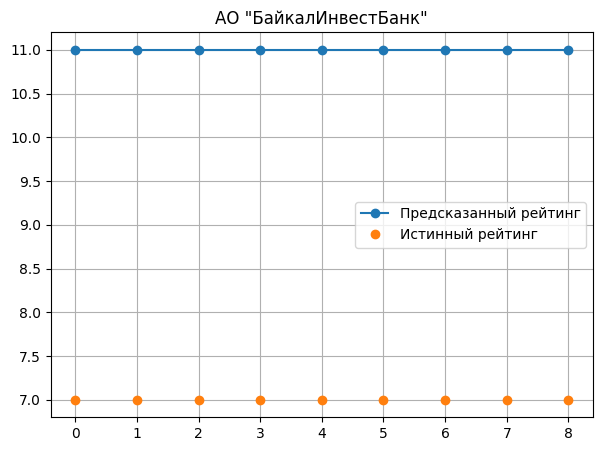

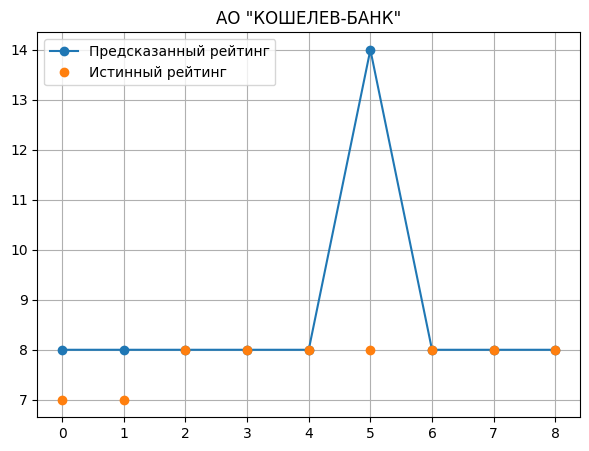

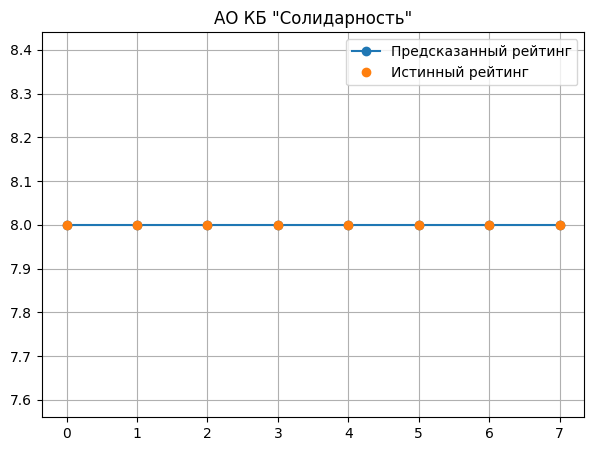

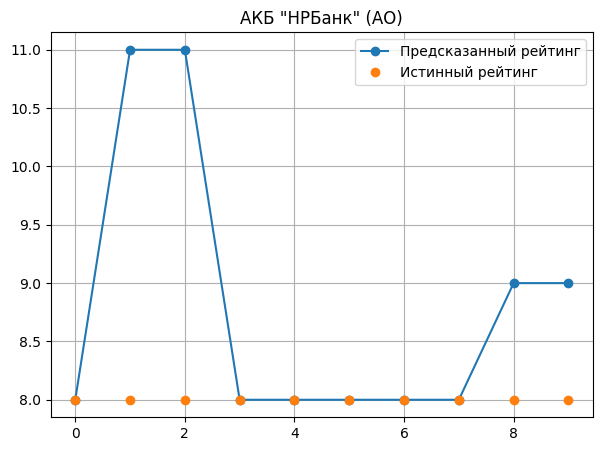

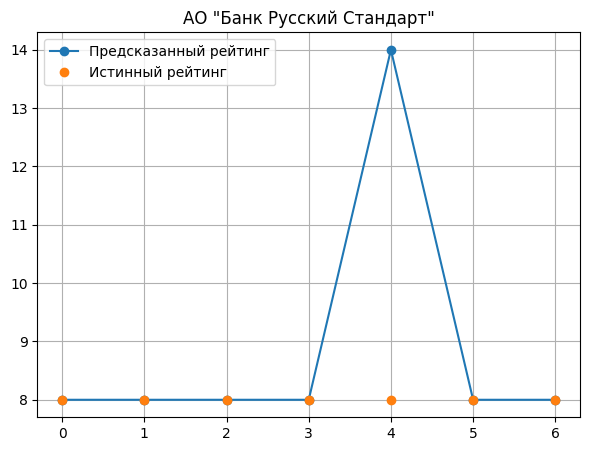

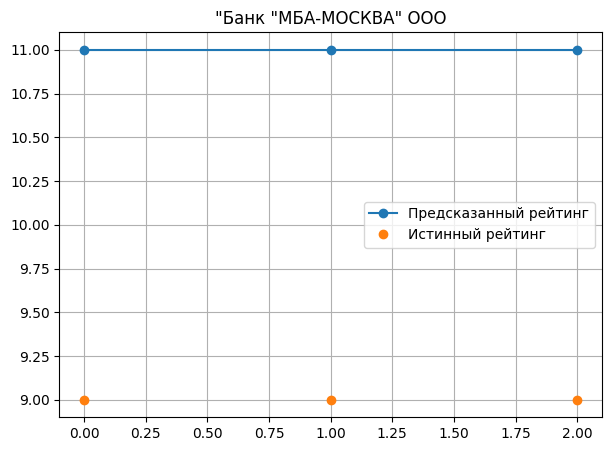

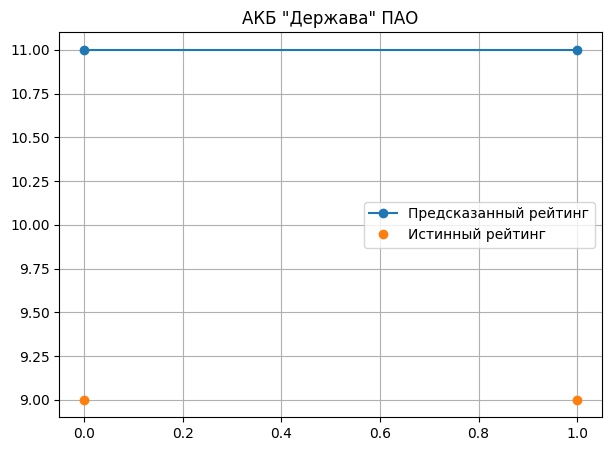

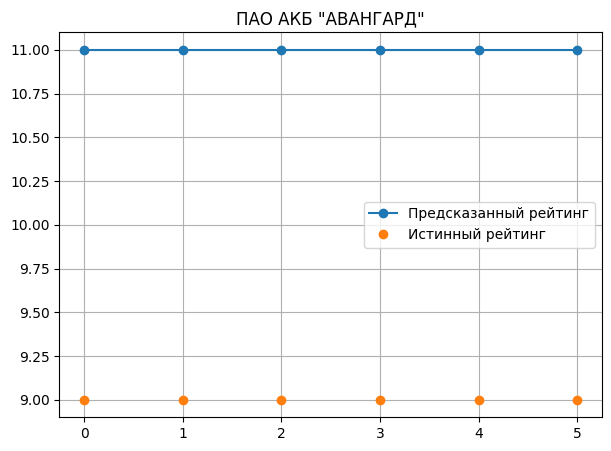

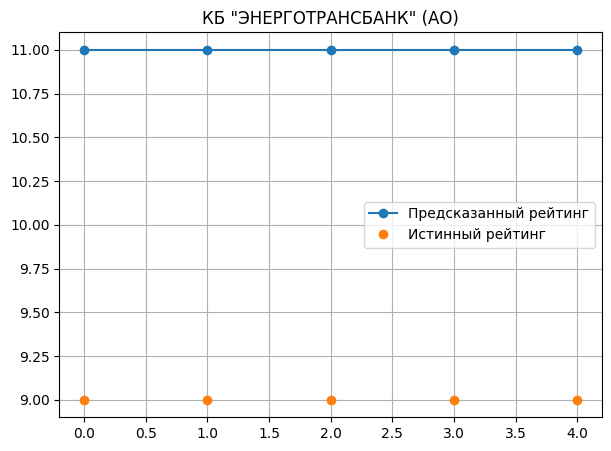

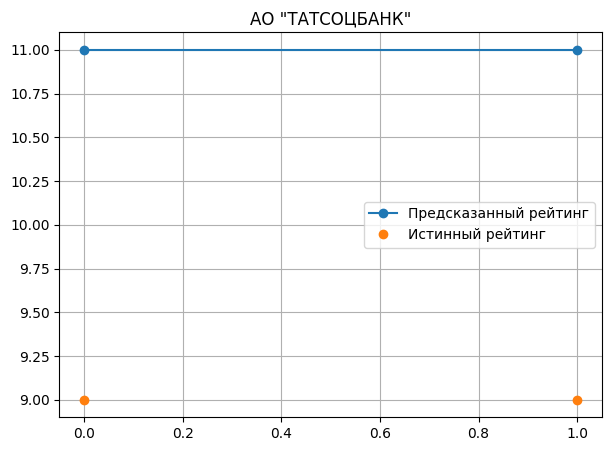

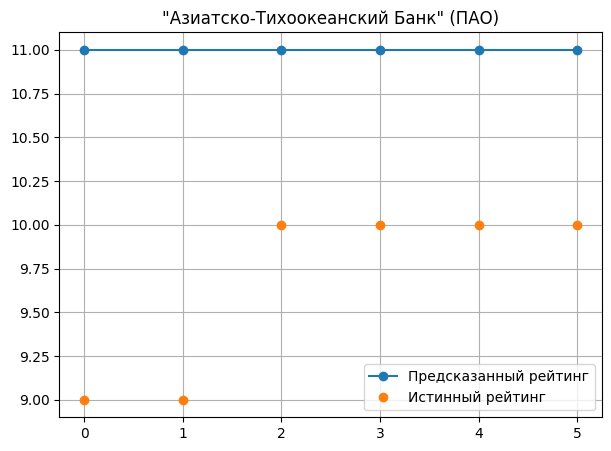

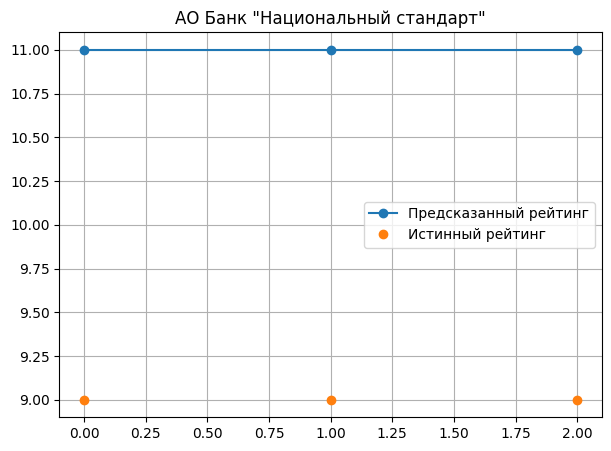

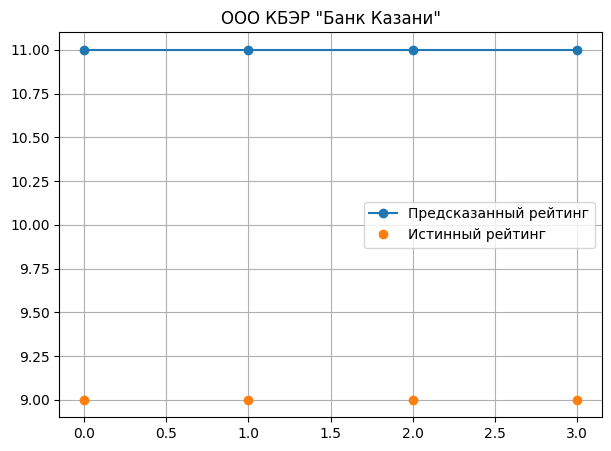

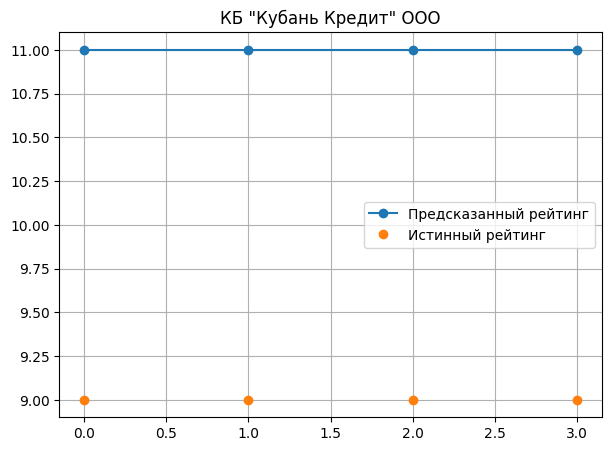

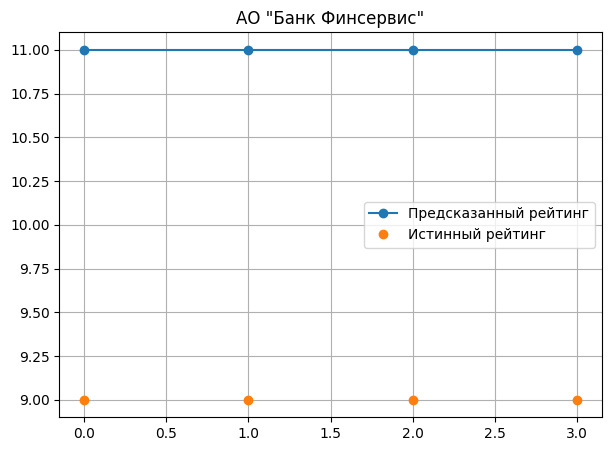

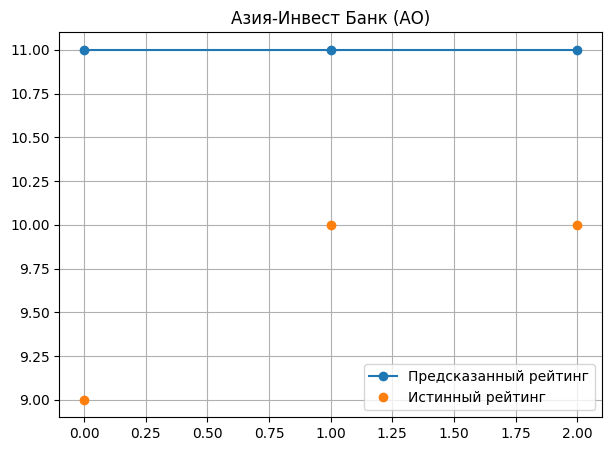

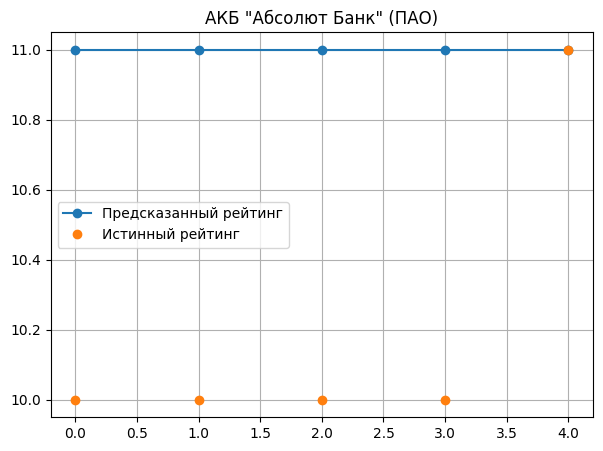

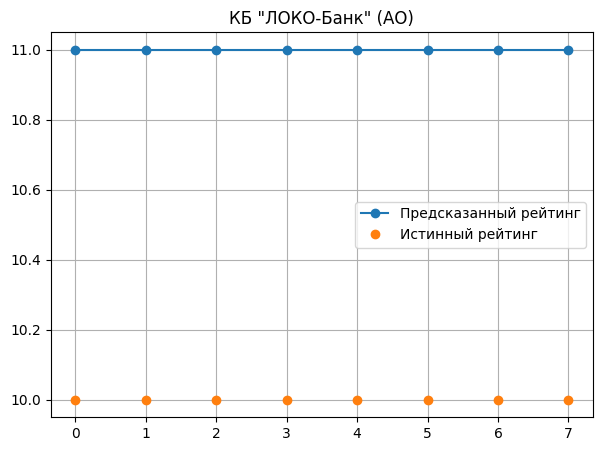

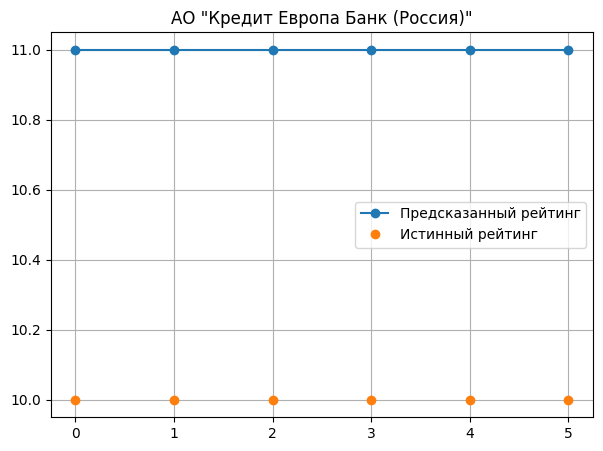

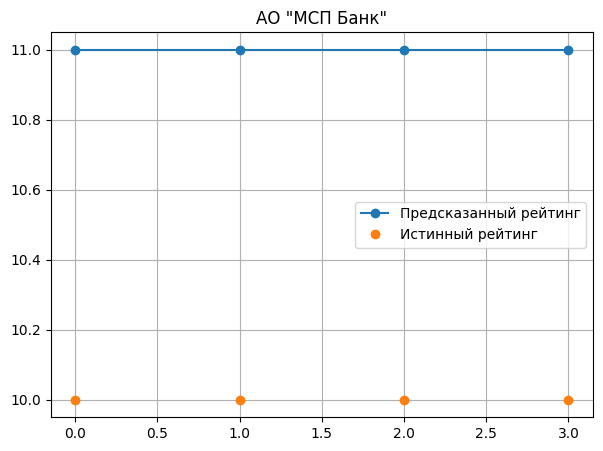

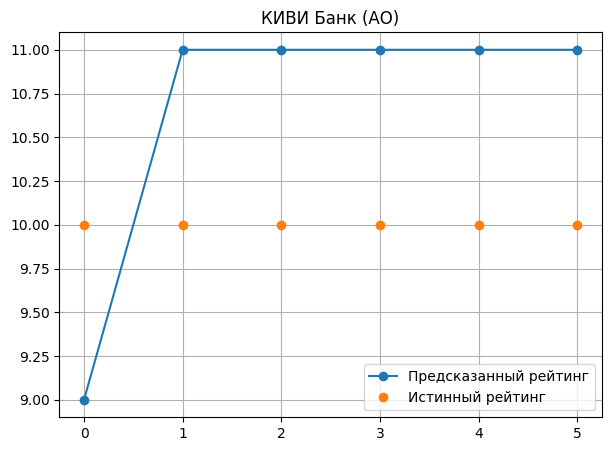

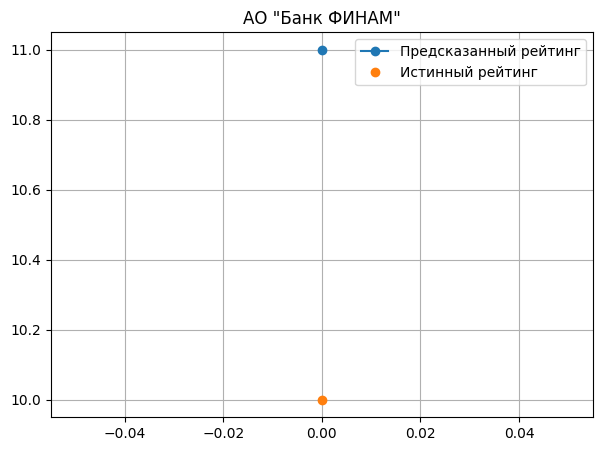

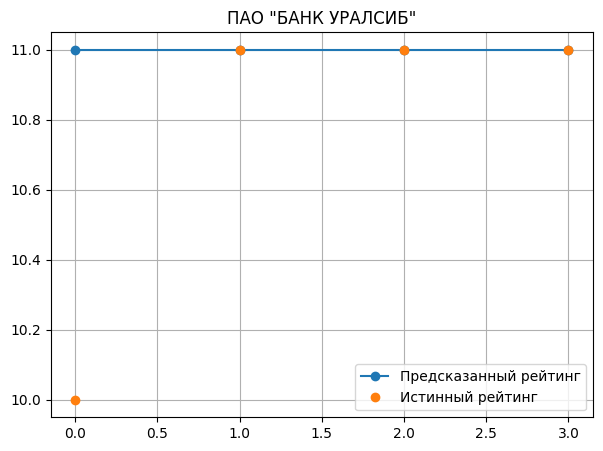

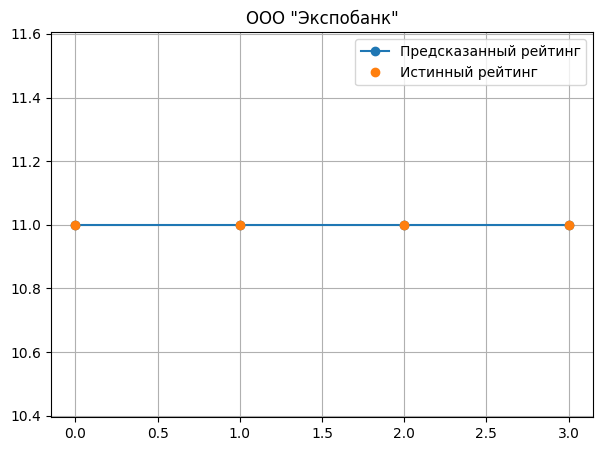

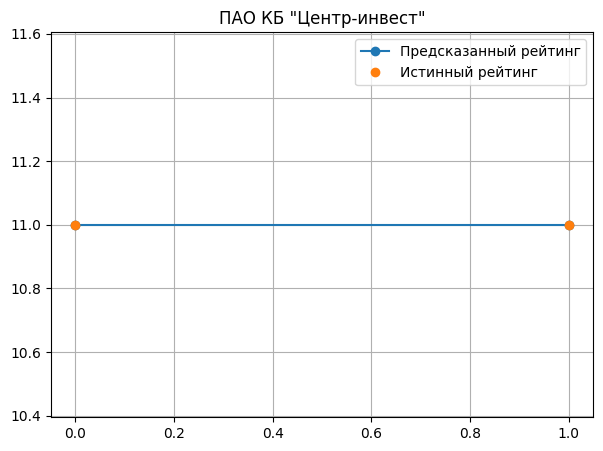

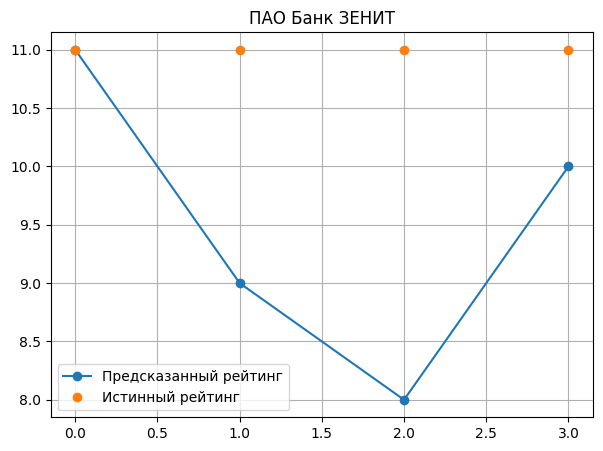

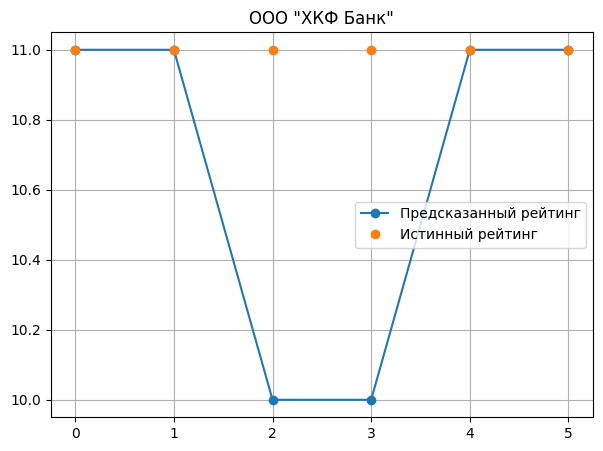

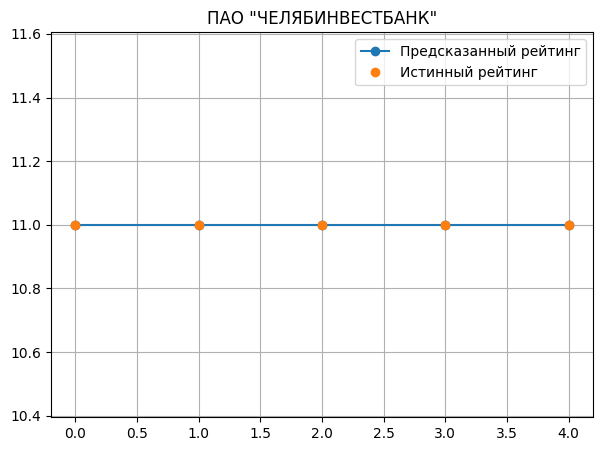

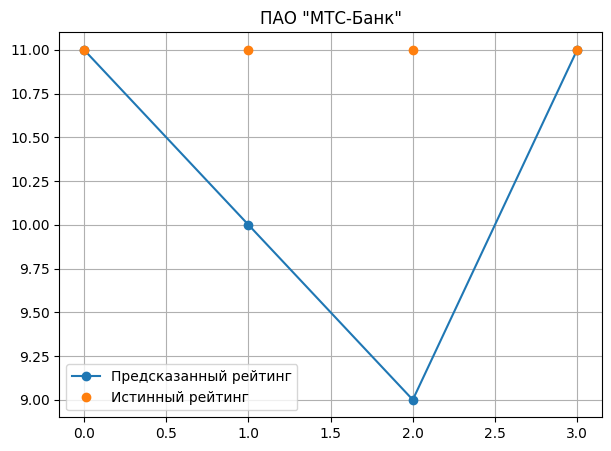

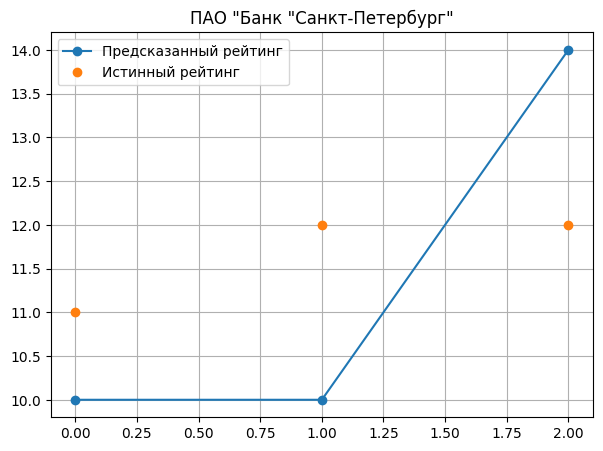

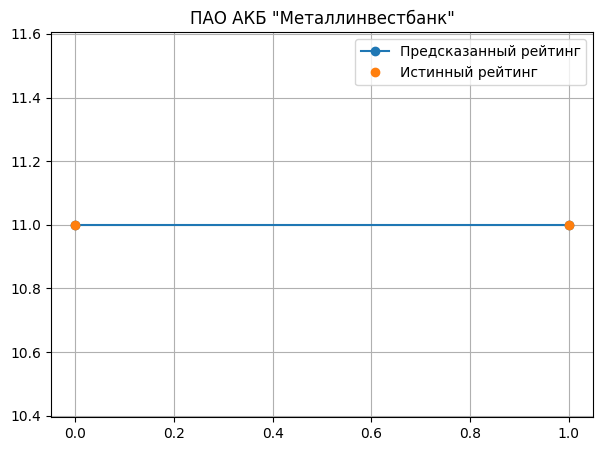

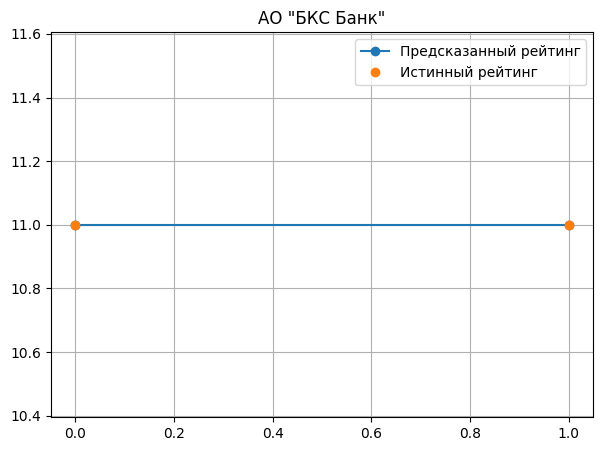

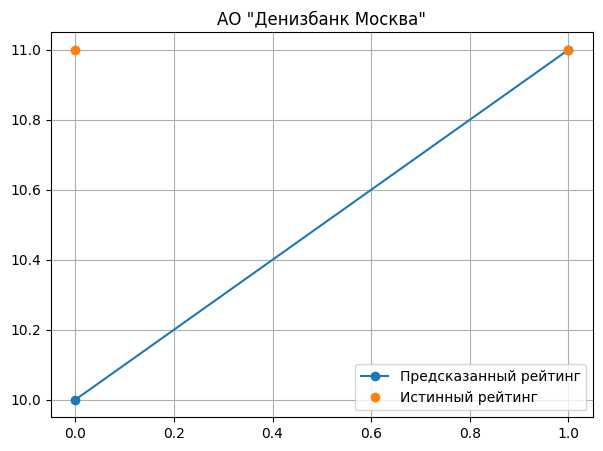

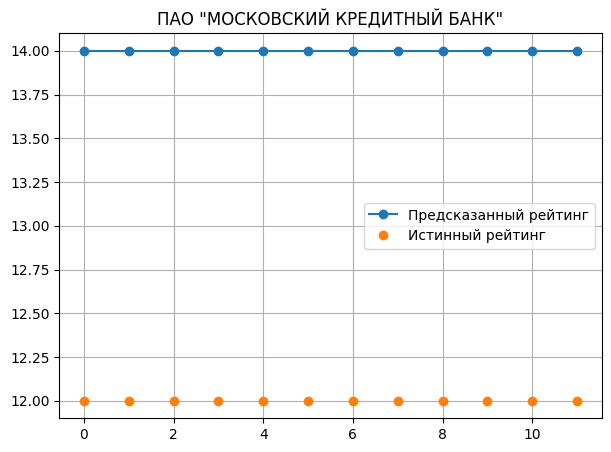

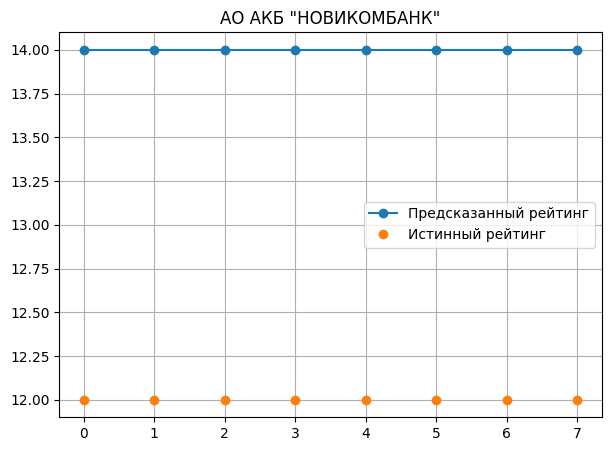

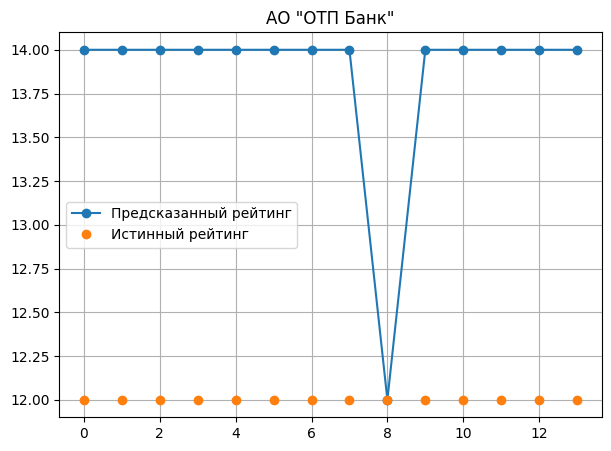

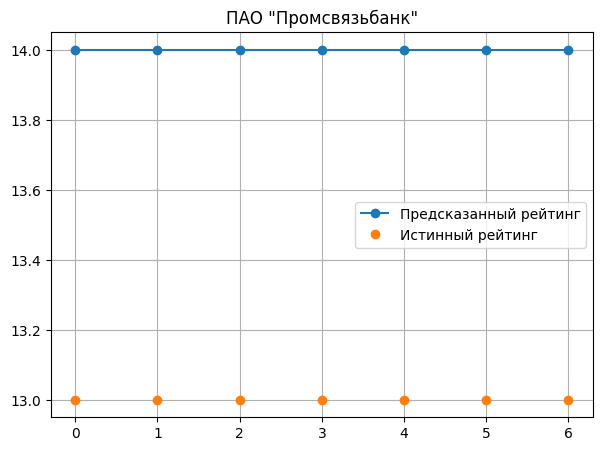

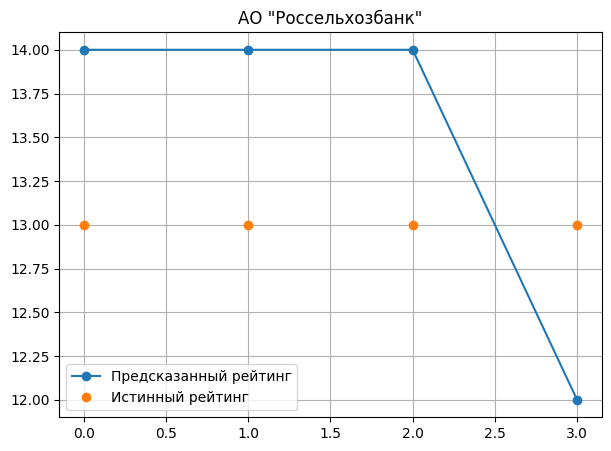

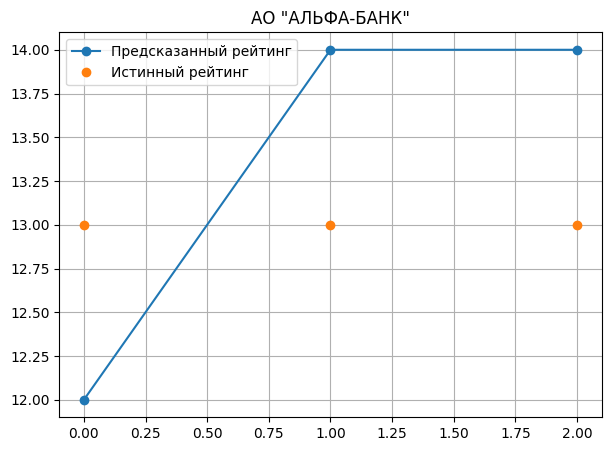

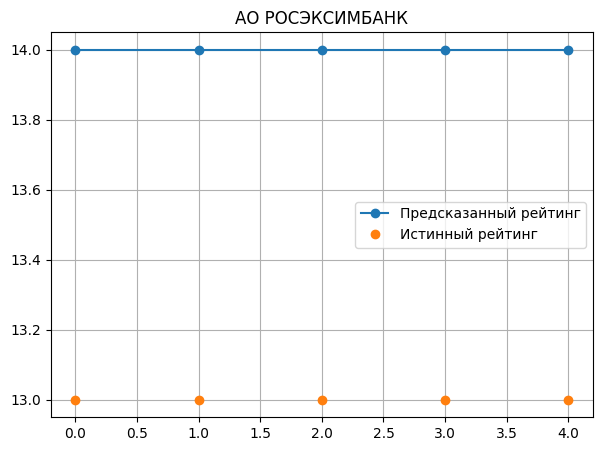

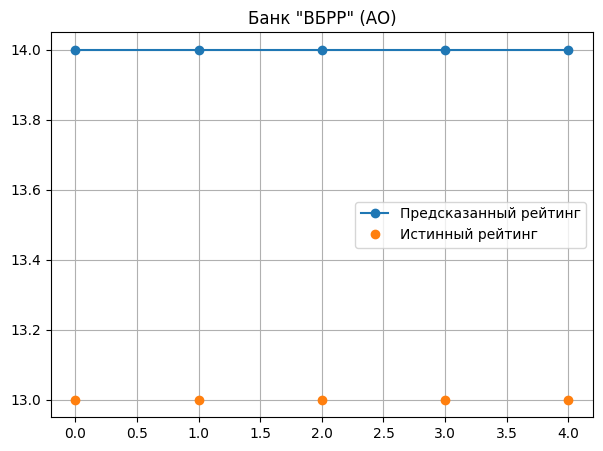

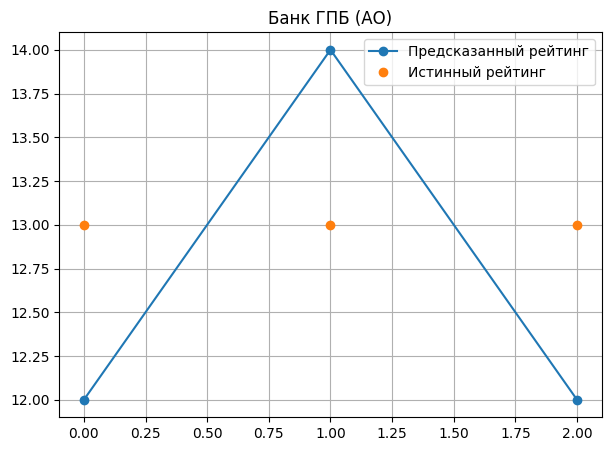

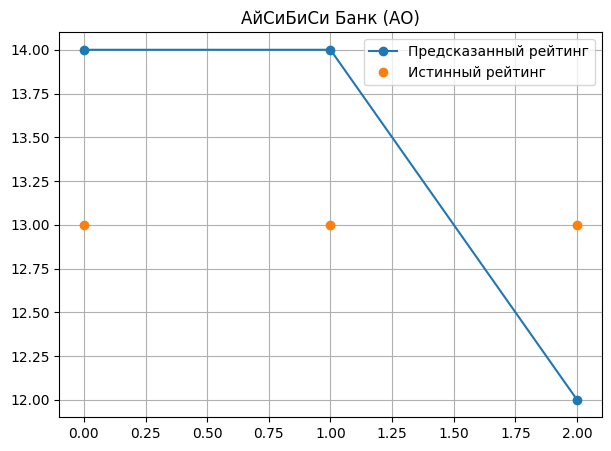

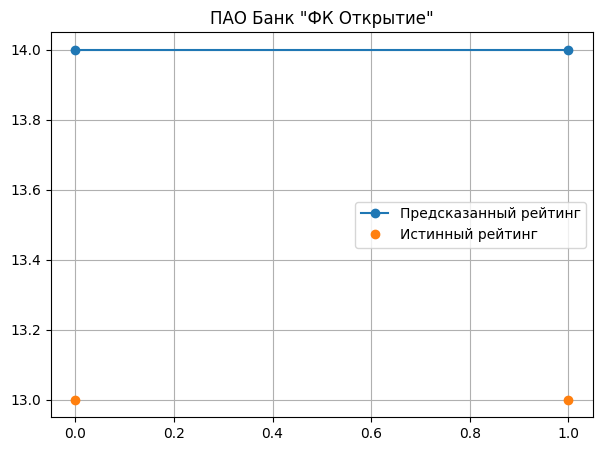

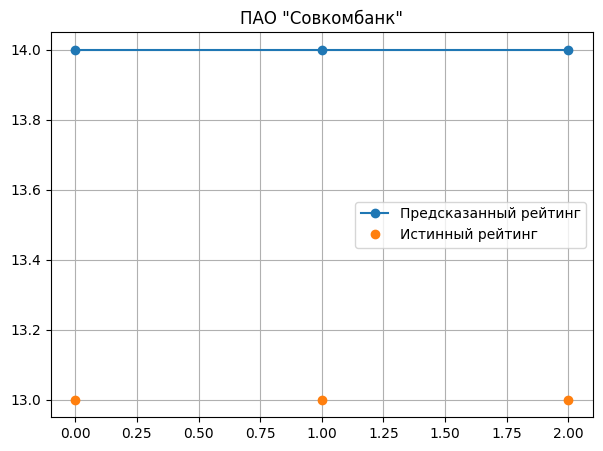

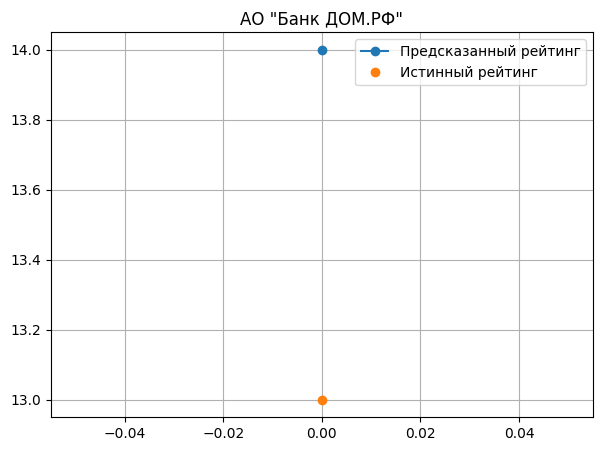

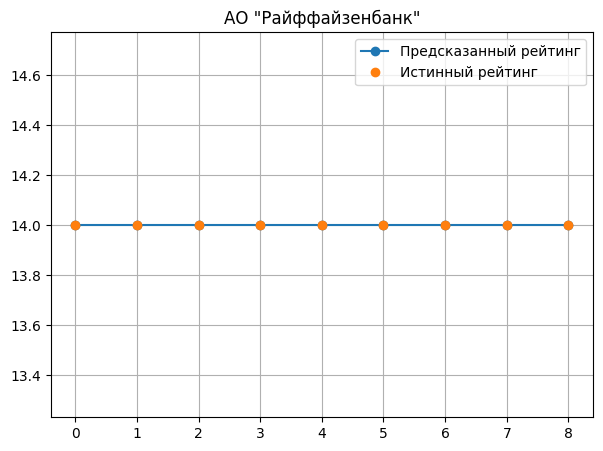

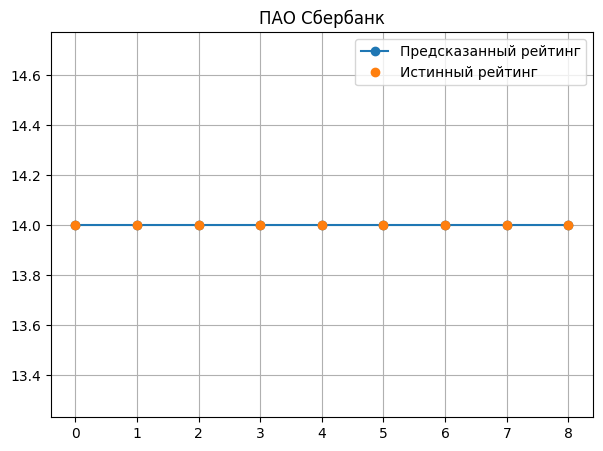

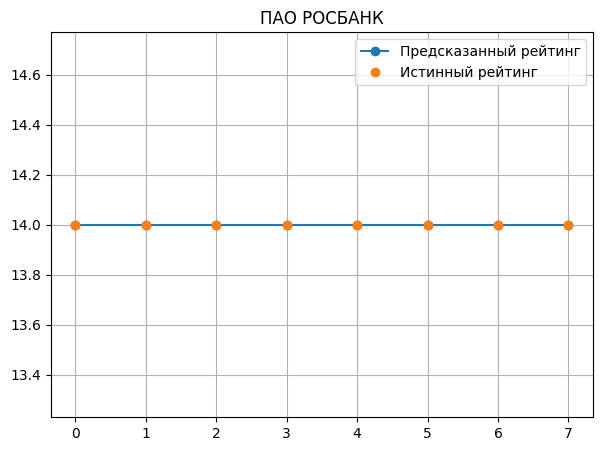

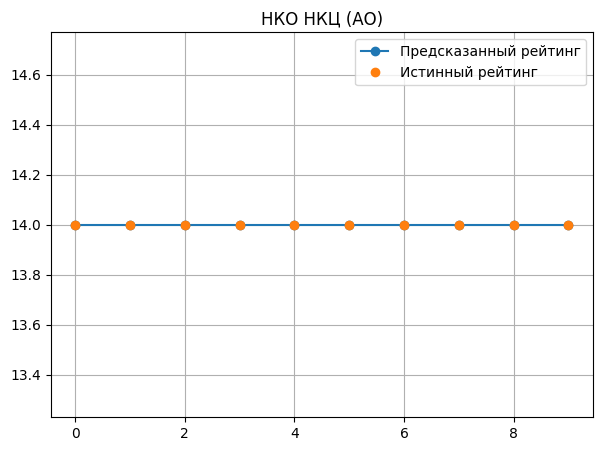

In [24]:
for bank in df_predict['index_bank'].unique():
    df_onebank = df_predict.loc[df_predict['index_bank'] == bank]
#     df_onebank['External_rating'] = score_cat(df_onebank['External_rating'])
    external_numpy_bank = df_onebank['true_rate'].values.reshape(-1, 1)
    y_pred_bank = df_onebank['predict_rate'].values.reshape(-1, 1)
    # external_numpy_bank = external_numpy_bank
    # date_numpy_bank = df_onebank['report_date'].values.reshape(-1, 1)  
    
    # df_bank_drop = df_onebank.drop("External_rating", axis = 1) 
    # df_bank_drop = df_bank_drop.drop("report_date", axis = 1) 
    # # переводим в numpy df_cat_drop, External_rating
    # df_numpy_business = df_bank_drop[df_bank_drop.columns[:77]].values
    # df_numpy_finance = df_bank_drop[df_bank_drop.columns[77:]].values

    # # перемножаем матрицу признаков на веса df_numpy_bank * w
    # y_pred_bank_bus = np.dot(df_numpy_business, w_triplets_dvum[:77])
    # y_pred_bank_fin = np.dot(df_numpy_finance, w_triplets_dvum[77:])
    # делаем категорию
    # y_pred_bank = score_cat(y_pred_bank)
    # предсказание
#     y_pred_bank = model.predict(y_pred_bank)
    # рейтинг в баллах (дф признаков * веса после триплета)
    # X_test = np.column_stack((y_pred_bank_bus, y_pred_bank_fin))
    
    # # предсказание
    # y_pred_bank = model.predict(X_test)
    
    plt.figure(figsize=(7, 5))
    plt.plot(y_pred_bank, label='Предсказанный рейтинг', marker='o')
    plt.plot(external_numpy_bank, label='Истинный рейтинг', marker='o', linestyle='None')
    plt.title(bank)
    plt.legend()
    plt.grid(True)
    plt.show()